## Read ReadMe for instructions

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgboost
import re
from sentence_transformers import SentenceTransformer
from datetime import datetime
pd.set_option('display.max_columns', None)

In [5]:
accepted_df = pd.read_csv("datasets/accepted_dataset.csv")
rejected_df = pd.read_csv("datasets/rejected_dataset.csv")

/var/folders/9b/6_8zt65542g2nv99zls1h_nr0000gn/T/ipykernel_52729/3125798192.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  accepted_df = pd.read_csv("datasets/accepted_dataset.csv")


## Formatting

In [6]:
# --- Step 1: Add Target Status ---
accepted_df['status'] = 1
rejected_df['status'] = 0

# --- Step 2 & 3: Rename and Select Columns (Rejected) ---
print("Preprocessing Rejected Loans...")
# Rename columns in rejected_df to match accepted_df conventions
rename_map_rejected = {
    'Amount Requested': 'loan_amnt',
    'Application Date': 'application_date_str', # Keep temporary string name
    'Loan Title': 'purpose',
    'Risk_Score': 'fico_score',          # Assuming Risk_Score maps to FICO
    'Debt-To-Income Ratio': 'dti_str',  # Keep temporary string name
    'State': 'addr_state',
    'Employment Length': 'emp_length_str', # Keep temporary string name
    # Add 'Zip Code': 'zip_code' if needed
    # Add 'Policy Code': 'policy_code' if needed
}
# Select only the columns we intend to map plus the status
cols_to_keep_rejected = list(rename_map_rejected.keys()) + ['status']
rejected_df_processed = rejected_df[cols_to_keep_rejected].copy()
rejected_df_processed.rename(columns=rename_map_rejected, inplace=True)
rejected_df_processed = rejected_df_processed.sort_index(axis=1)

print("Preprocessing Accepted Loans...")
# Select corresponding columns plus the status
# We need 'issue_d' for date, 'fico_range_low' for score, raw 'dti', raw 'emp_length'
cols_to_keep_accepted = [
    'loan_amnt',
    'issue_d',          # Use as proxy for application date
    'purpose',
    'dti',              # Raw DTI
    'addr_state',
    'emp_length',       # Raw emp_length
    'fico_range_low',   # Use low end of FICO range
    'status'
    # Add 'zip_code' if needed
    # Add 'policy_code' if needed
]
# Filter out potential columns not present in older datasets if necessary
available_cols_accepted = [col for col in cols_to_keep_accepted if col in accepted_df.columns]
accepted_df_processed = accepted_df[available_cols_accepted].copy()

# Rename accepted columns to standardized names
accepted_df_processed.rename(columns={
    'issue_d': 'application_date_str',
    'fico_range_low': 'fico_score',
    'emp_length': 'emp_length_str', # Keep temp name before cleaning
    'dti': 'dti_str'             # Keep temp name before cleaning
}, inplace=True)

accepted_df_processed = accepted_df_processed.sort_index(axis=1)

print("Standardizing data types...")
accepted_df_processed['application_date_str'] = pd.to_datetime(accepted_df_processed['application_date_str'], format='%b-%Y').dt.strftime('%Y-%m-%d')
accepted_df_processed['application_date_str'] = pd.to_datetime(accepted_df_processed['application_date_str'], errors='coerce')
rejected_df_processed['application_date_str'] = pd.to_datetime(rejected_df_processed['application_date_str'], errors='coerce')
rejected_df_processed['dti_str'] = rejected_df_processed['dti_str'].str.replace('%', '').astype(float)
emp_length_mapping = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}

accepted_df_processed['emp_length_str'] = accepted_df_processed['emp_length_str'].map(emp_length_mapping)
rejected_df_processed['emp_length_str'] = rejected_df_processed['emp_length_str'].map(emp_length_mapping)
accepted_df_processed['emp_length_str'] = accepted_df_processed['emp_length_str'].astype(float)
rejected_df_processed['emp_length_str'] = rejected_df_processed['emp_length_str'].astype(float)
accepted_df_processed['purpose'] = accepted_df_processed['purpose'].str.replace('_', ' ')
rejected_df_processed['purpose'] = rejected_df_processed['purpose'].str.replace('_', ' ')
accepted_df_processed['purpose'] = accepted_df_processed['purpose'].str.lower()
rejected_df_processed['purpose'] = rejected_df_processed['purpose'].str.lower()

accepted_final = accepted_df_processed.copy()
rejected_final = rejected_df_processed.copy()

accepted_final = accepted_final.rename(columns={'application_date_str': 'application_date', 'emp_length_str':'emp_length', 'dti_str':'dti'})
rejected_final = rejected_final.rename(columns={'application_date_str': 'application_date', 'emp_length_str':'emp_length', 'dti_str':'dti'})

# Drop rows where the application date is missing, as it's crucial for temporal split
accepted_final.dropna(subset=['application_date'], inplace=True)
rejected_final.dropna(subset=['application_date'], inplace=True)

# --- Step 7: Handle Missing Values ---
print("Handling missing values...")
print("Missing values before imputation:")
print(accepted_final.isnull().sum())
print(rejected_final.isnull().sum())
print("Dropping null")
accepted_final = accepted_final.dropna()
rejected_final = rejected_final.dropna()
# print(rejected_final.isnull().sum())

print("Splitting data by time period...")
accepted_final['year'] = accepted_final['application_date'].dt.year
rejected_final['year'] = rejected_final['application_date'].dt.year

recession_years = range(2007, 2013) # 2007-2012 inclusive
post_recession_years = range(2013, 2019) # 2013-2018 inclusive

accepted_final_recession_df = accepted_final[accepted_final['year'].isin(recession_years)].copy()
accepted_final_post_recession_df = accepted_final[accepted_final['year'].isin(post_recession_years)].copy()

rejected_final_recession_df = rejected_final[rejected_final['year'].isin(recession_years)].copy()
rejected_final_post_recession_df = rejected_final[rejected_final['year'].isin(post_recession_years)].copy()

# Drop the date and year columns as they are no longer needed for modeling itself
accepted_final_recession_df.drop(columns=['application_date'], inplace=True)
accepted_final_post_recession_df.drop(columns=['application_date'], inplace=True)
rejected_final_recession_df.drop(columns=['application_date'], inplace=True)
rejected_final_post_recession_df.drop(columns=['application_date'], inplace=True)

print(f"\nRecession Era (2007-2012) dataset shape:\n -> Accepted: {len(accepted_final_recession_df)}\n -> Rejected: {len(rejected_final_recession_df)}")
print(f"\nPost-Recession Era (2013-2018) dataset shape:\n -> Accepted: {len(accepted_final_post_recession_df)}\n -> Rejected: {len(rejected_final_post_recession_df)}")

Preprocessing Rejected Loans...
Preprocessing Accepted Loans...
Standardizing data types...
Handling missing values...
Missing values before imputation:
addr_state               0
application_date         0
dti                   1711
emp_length          146907
fico_score               0
loan_amnt                0
purpose                  0
status                   0
dtype: int64
addr_state                22
application_date           0
dti                        0
emp_length            951355
fico_score          18497630
loan_amnt                  0
purpose                 1305
status                     0
dtype: int64
Dropping null
Splitting data by time period...

Recession Era (2007-2012) dataset shape:
 -> Accepted: 92865
 -> Rejected: 723523

Post-Recession Era (2013-2018) dataset shape:
 -> Accepted: 2020783
 -> Rejected: 8269041


In [7]:
max_rows = min(len(accepted_final_recession_df), len(accepted_final_post_recession_df), len(rejected_final_recession_df), len(rejected_final_post_recession_df))
print(f"Cutting all dataframes to length '{max_rows}'")
random_shuffle_seed = 42
accepted_final_recession_df = accepted_final_recession_df.sample(frac=1, random_state=random_shuffle_seed)
accepted_final_post_recession_df = accepted_final_post_recession_df.sample(frac=1, random_state=random_shuffle_seed)
rejected_final_recession_df = rejected_final_recession_df.sample(frac=1, random_state=random_shuffle_seed)
rejected_final_post_recession_df = rejected_final_post_recession_df.sample(frac=1, random_state=random_shuffle_seed)

accepted_final_recession_df = accepted_final_recession_df.head(max_rows)
accepted_final_post_recession_df = accepted_final_post_recession_df.head(max_rows)
rejected_final_recession_df = rejected_final_recession_df.head(max_rows)
rejected_final_post_recession_df = rejected_final_post_recession_df.head(max_rows)

print(f"\nRecession Era (2007-2012) dataset shape:\n -> Accepted: {len(accepted_final_recession_df)}\n -> Rejected: {len(rejected_final_recession_df)}")
print(f"\nPost-Recession Era (2013-2018) dataset shape:\n -> Accepted: {len(accepted_final_post_recession_df)}\n -> Rejected: {len(rejected_final_post_recession_df)}")

Cutting all dataframes to length '92865'

Recession Era (2007-2012) dataset shape:
 -> Accepted: 92865
 -> Rejected: 92865

Post-Recession Era (2013-2018) dataset shape:
 -> Accepted: 92865
 -> Rejected: 92865


In [8]:
# --- Step 6: Combine DataFrames ---
print("Combining datasets...")
combined_df = pd.concat([accepted_final_recession_df, accepted_final_post_recession_df, rejected_final_recession_df, rejected_final_post_recession_df], ignore_index=True)
print(f"Combined dataset shape: {combined_df.shape}")

# --- 1. Preprocessing ---
print(f"[{datetime.now().strftime('%H:%M:%S')}] Starting preprocessing...")
combined_df = combined_df.reset_index(drop=True)
unique_purposes = combined_df['purpose'].unique()
print(f"[{datetime.now().strftime('%H:%M:%S')}] Found {len(unique_purposes)} unique purposes")

# --- 2. Generate Embeddings ---
print(f"[{datetime.now().strftime('%H:%M:%S')}] Loading model...")
model = SentenceTransformer('paraphrase-MiniLM-L3-v2')

print(f"[{datetime.now().strftime('%H:%M:%S')}] Encoding {len(unique_purposes)} purposes (batch_size=512)...")
unique_embeddings = model.encode(unique_purposes, 
                               batch_size=512, 
                               show_progress_bar=True, 
                               convert_to_numpy=True)
print(f"[{datetime.now().strftime('%H:%M:%S')}] Embeddings generated: {unique_embeddings.shape}")

# --- 3. Create Embedding Dictionary ---
print(f"[{datetime.now().strftime('%H:%M:%S')}] Creating embedding dictionary...")
embedding_dict = dict(zip(unique_purposes, unique_embeddings))

# --- 4. Map Embeddings to DataFrame ---
print(f"[{datetime.now().strftime('%H:%M:%S')}] Mapping embeddings to {len(combined_df)} rows...")
combined_df['embedding_array'] = combined_df['purpose'].map(embedding_dict)

# Check for missing embeddings
missing = combined_df['embedding_array'].isna().sum()
print(f"[{datetime.now().strftime('%H:%M:%S')}] Missing embeddings: {missing} rows")
if missing > 0:
    combined_df['embedding_array'] = combined_df['embedding_array'].apply(
        lambda x: np.zeros(unique_embeddings.shape[1]) if x is None else x
    )

# --- 5. Convert to Columns ---
print(f"[{datetime.now().strftime('%H:%M:%S')}] Creating embedding columns...")
embedding_columns = pd.DataFrame(
    np.vstack(combined_df['embedding_array']),
    columns=[f'purpose_embed_{i}' for i in range(unique_embeddings.shape[1])],
    index=combined_df.index
)
print(f"[{datetime.now().strftime('%H:%M:%S')}] Embedding columns created: {embedding_columns.shape}")
combined_df = combined_df.drop(['purpose', 'embedding_array'], axis=1)
combined_df = pd.merge(combined_df, embedding_columns, left_index=True, right_index=True)

# One-hot encode 'addr_state'
combined_df = pd.get_dummies(
    combined_df, 
    columns=['addr_state'], 
    prefix='state', 
    dtype=np.int8  # Reduces memory usage by 75% vs float64
)

# --- Step 9: Extract Year and Temporal Split ---
# Define time periods
recession_years = range(2007, 2013) # 2007-2012 inclusive
post_recession_years = range(2013, 2019) # 2013-2018 inclusive

recession_df = combined_df[combined_df['year'].isin(recession_years)].copy()
post_recession_df = combined_df[combined_df['year'].isin(post_recession_years)].copy()

# Drop the date and year columns as they are no longer needed for modeling itself
recession_df.drop(columns=['year'], inplace=True)
post_recession_df.drop(columns=['year'], inplace=True)

print(f"Recession Era (2007-2012) dataset shape: {recession_df.shape}")
print(f"Post-Recession Era (2013-2018) dataset shape: {post_recession_df.shape}")

# --- Final Check ---
print("\nPreprocessing Complete.")
print("\nRecession Data Info:")
recession_df.info()
print("\nPost-Recession Data Info:")
post_recession_df.info()

Combining datasets...
Combined dataset shape: (371460, 8)
[11:17:47] Starting preprocessing...
[11:17:47] Found 7880 unique purposes
[11:17:47] Loading model...
[11:17:49] Encoding 7880 purposes (batch_size=512)...


Batches: 100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


[11:17:52] Embeddings generated: (7880, 384)
[11:17:52] Creating embedding dictionary...
[11:17:52] Mapping embeddings to 371460 rows...
[11:17:53] Missing embeddings: 0 rows
[11:17:53] Creating embedding columns...
[11:17:53] Embedding columns created: (371460, 384)
Recession Era (2007-2012) dataset shape: (185730, 440)
Post-Recession Era (2013-2018) dataset shape: (185730, 440)

Preprocessing Complete.

Recession Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 185730 entries, 0 to 278594
Columns: 440 entries, dti to state_WY
dtypes: float32(384), float64(4), int64(1), int8(51)
memory usage: 289.6 MB

Post-Recession Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 185730 entries, 92865 to 371459
Columns: 440 entries, dti to state_WY
dtypes: float32(384), float64(4), int64(1), int8(51)
memory usage: 289.6 MB


## Models

## Recession

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np # Used for handling potential NaN/inf after scaling
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# --- 1. Load and Prepare Data ---
# Assume 'recession_df' is your pre-loaded DataFrame
# recession_df = pd.read_csv('your_data.csv') # Or however you load it

print("Original DataFrame Info:")
recession_df.info()
print(f"\nTarget variable 'status' unique values: {recession_df['status'].unique()}")

# Define features (X) and target (y)
target_column = 'status'
X = recession_df.drop(target_column, axis=1)
y = recession_df[target_column]

# --- 2. Encode Target Variable ---
# Models require numerical target variables. If 'status' is categorical (e.g., strings),
# encode it into integers.
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"\nEncoded target classes: {le.classes_}") # Shows mapping: 0 -> class1, 1 -> class2, etc.

# --- 3. Split Data into Training and Testing Sets ---
# Use stratify=y_encoded to maintain class proportions in train/test splits,
# which is important for classification, especially if classes are imbalanced.
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.3,        # 30% for testing, 70% for training
    random_state=42,      # For reproducibility
    stratify=y_encoded    # Keep class distribution consistent
)

print(f"\nTraining set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")


# --- 4. Scale Features ---
# Although tree-based models aren't strictly sensitive to feature scaling,
# it's good practice and can sometimes help, especially with regularization (like in XGBoost).
# Important: Fit the scaler ONLY on the training data, then transform both train and test data.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle potential NaNs or Infs that might arise from scaling (if columns had zero variance)
X_train_scaled = np.nan_to_num(X_train_scaled)
X_test_scaled = np.nan_to_num(X_test_scaled)

# Convert scaled arrays back to DataFrames (optional, but can be helpful for inspection)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)


# --- 5. Define and Train Models ---

# --- Random Forest ---
print("\n--- Training Random Forest ---")
rf_model = RandomForestClassifier(
    n_estimators=100,     # Number of trees in the forest (common starting point)
    random_state=42,      # For reproducibility
    n_jobs=-1,            # Use all available CPU cores
    class_weight='balanced' # Useful if classes are imbalanced
)
rf_model.fit(X_train_scaled, y_train)
print("Random Forest training complete.")

# --- Bagging (Bootstrap Aggregating) ---
# Often used with Decision Trees as the base estimator (default if None is specified)
print("\n--- Training Bagging Classifier ---")
bagging_model = BaggingClassifier(
    n_estimators=50,
    random_state=42,
    n_jobs=-1  # Keep using parallelism here if desired
)
# The warning should now be gone
bagging_model.fit(X_train_scaled, y_train)
print("Bagging Classifier training complete.")


# --- XGBoost ---
print("\n--- Training XGBoost Classifier ---")
xgb_model = XGBClassifier(
    n_estimators=100,     # Number of boosting rounds (trees)
    learning_rate=0.1,    # Step size shrinkage to prevent overfitting
    max_depth=3,          # Maximum depth of a tree (common starting point)
    random_state=42,      # For reproducibility
    n_jobs=-1,            # Use all available CPU cores
    use_label_encoder=False, # Recommended to avoid deprecation warnings
    eval_metric='logloss' # Common evaluation metric for binary/multi-class classification
    # Add 'scale_pos_weight' here if dealing with imbalanced classes, e.g.,
    # scale_pos_weight = sum(y_train == 0) / sum(y_train == 1) # For binary
)
xgb_model.fit(X_train_scaled, y_train)
print("XGBoost training complete.")


# --- 6. Make Predictions on Test Set ---

rf_preds = rf_model.predict(X_test_scaled)
bagging_preds = bagging_model.predict(X_test_scaled)
xgb_preds = xgb_model.predict(X_test_scaled)
# --- 7. Evaluate Models ---

models = {
    "Random Forest": rf_preds,
    "Bagging": bagging_preds,
    "XGBoost": xgb_preds
}

# Get the original class labels detected by the encoder
# These might be numbers (e.g., array([0, 1])) if your original 'status' was numeric
class_labels = le.classes_

# *** FIX: Convert class labels to strings for the report ***
# The classification_report expects string names in target_names.
class_names_str = [str(c) for c in class_labels]
print(f"\nUsing string class names for report: {class_names_str}") # Debug print

print("\n--- Model Evaluation ---")

for model_name, y_pred in models.items():
    print(f"\n--- {model_name} Results ---")

    # Calculate Metrics
    accuracy = accuracy_score(y_test, y_pred)
    # Determine averaging strategy based on the number of unique classes
    num_classes = len(class_labels)
    avg_strategy = 'weighted' if num_classes > 2 else 'binary'
    # Determine positive label ONLY for binary case (usually label 1)
    # Check if 1 exists in the encoded labels before assigning
    pos_label = 1 if avg_strategy == 'binary' and 1 in y_encoded else None

    precision = precision_score(y_test, y_pred, average=avg_strategy, pos_label=pos_label, zero_division=0)
    recall = recall_score(y_test, y_pred, average=avg_strategy, pos_label=pos_label, zero_division=0)
    f1 = f1_score(y_test, y_pred, average=avg_strategy, pos_label=pos_label, zero_division=0)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision ({avg_strategy} avg): {precision:.4f}")
    print(f"Recall ({avg_strategy} avg): {recall:.4f}")
    print(f"F1-Score ({avg_strategy} avg): {f1:.4f}")

    print("\nConfusion Matrix:")
    # Pass the actual numerical labels for the confusion matrix if needed for specific order
    print(confusion_matrix(y_test, y_pred, labels=np.unique(y_encoded))) # Ensure order if necessary

    print("\nClassification Report:")
    # *** Use the STRING version of class names for target_names ***
    print(classification_report(y_test, y_pred, target_names=class_names_str, zero_division=0))

# --- 8. Determine Best Performance (Based on your criteria) ---
# (Rest of the code for comparison remains the same, using the calculated f1_scores dict)
# Make sure the f1_score calculation here also uses the correct avg_strategy and pos_label
f1_scores = {
    "Random Forest": f1_score(y_test, rf_preds, average=avg_strategy, pos_label=pos_label, zero_division=0),
    "Bagging": f1_score(y_test, bagging_preds, average=avg_strategy, pos_label=pos_label, zero_division=0),
    "XGBoost": f1_score(y_test, xgb_preds, average=avg_strategy, pos_label=pos_label, zero_division=0)
}

best_model_name = max(f1_scores, key=f1_scores.get)
print(f"\n--- Best Performing Model (based on {avg_strategy} F1-Score) ---")
print(f"Model: {best_model_name}")
print(f"F1-Score: {f1_scores[best_model_name]:.4f}")

# --- Optional: Feature Importance (for tree-based models) ---
# Helps understand which features are most influential
if hasattr(rf_model, 'feature_importances_'):
    print("\n--- Random Forest Feature Importances (Top 10) ---")
    rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
    print(rf_importances.nlargest(10))

if hasattr(xgb_model, 'feature_importances_'):
    print("\n--- XGBoost Feature Importances (Top 10) ---")
    xgb_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
    print(xgb_importances.nlargest(10))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
import joblib
import time

# --- 1. Load and Prepare Data ---
def load_and_explore_data(df):
    """
    Perform initial data exploration and preprocessing
    """
    print("Dataset Overview:")
    print(f"Shape: {df.shape}")
    print("\nData Types:")
    print(df.dtypes)
    
    # Check for missing values
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print("\nMissing Values:")
        print(missing[missing > 0])
        
    # Check for target class distribution
    print("\nTarget Distribution:")
    target_dist = df['status'].value_counts(normalize=True) * 100
    print(target_dist)
    
    # Plot target distribution
    plt.figure(figsize=(8, 5))
    sns.countplot(x='status', data=df)
    plt.title('Target Class Distribution')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('target_distribution.png')
    
    # Check for numeric feature correlations
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
    if len(numeric_features) > 1:
        plt.figure(figsize=(12, 10))
        correlation = df[numeric_features].corr()
        sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
        plt.title('Feature Correlation Matrix')
        plt.tight_layout()
    
    return df

def preprocess_data(df, target_column='status'):
    """
    Preprocess the data for modeling
    """
    # Define features (X) and target (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Encode target variable if categorical
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    print(f"\nEncoded target classes: {list(zip(le.classes_, range(len(le.classes_))))}")
    
    # Split data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded,
        test_size=0.3,
        random_state=42,
        stratify=y_encoded
    )
    
    print(f"\nTraining set shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")
    
    return X_train, X_test, y_train, y_test, le, X.columns

# --- 2. Feature Selection & Engineering ---
def feature_importance_selection(X_train, y_train, X_test, feature_names, threshold=0.01):
    """
    Select important features using Random Forest feature importance
    """
    print("\n--- Feature Selection Based on Importance ---")
    # Train a random forest for feature selection
    selector = RandomForestClassifier(n_estimators=100, random_state=42)
    selector.fit(X_train, y_train)
    
    # Get feature importances
    importances = pd.Series(selector.feature_importances_, index=feature_names)
    importances = importances.sort_values(ascending=False)
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    importances.head(20).plot(kind='bar')
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.savefig('feature_importances.png')
    
    # Select features above the threshold
    selector = SelectFromModel(selector, threshold=threshold, prefit=True)
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)
    
    # Get selected feature names
    selected_indices = selector.get_support()
    selected_features = feature_names[selected_indices]
    print(f"Selected {len(selected_features)} features out of {len(feature_names)}")
    print(f"Selected features: {selected_features.tolist()}")
    
    return X_train_selected, X_test_selected, selected_features

# --- 3. Handle Class Imbalance with SMOTE ---
def apply_smote(X_train, y_train):
    """
    Apply SMOTE to handle class imbalance
    """
    print("\n--- Handling Class Imbalance with SMOTE ---")
    # Check class distribution before SMOTE
    unique, counts = np.unique(y_train, return_counts=True)
    print(f"Class distribution before SMOTE: {dict(zip(unique, counts))}")
    
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # Check class distribution after SMOTE
    unique, counts = np.unique(y_train_resampled, return_counts=True)
    print(f"Class distribution after SMOTE: {dict(zip(unique, counts))}")
    
    return X_train_resampled, y_train_resampled

# --- 4. Build Modeling Pipeline ---
def create_model_pipelines():
    """
    Create machine learning model pipelines
    """
    # Random Forest pipeline
    rf_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestClassifier(random_state=42, n_jobs=-1))
    ])
    
    # Define hyperparameter grid for Random Forest
    rf_param_grid = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2],
        'model__class_weight': ['balanced', 'balanced_subsample', None]
    }
    
    # XGBoost pipeline
    xgb_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss'))
    ])
    
    # Define hyperparameter grid for XGBoost
    xgb_param_grid = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__subsample': [0.8, 1.0],
        'model__colsample_bytree': [0.8, 1.0]
    }
    
    return {
        'Random Forest': (rf_pipeline, rf_param_grid),
        'XGBoost': (xgb_pipeline, xgb_param_grid)
    }

# --- 5. Cross-validation and Hyperparameter Tuning ---
def tune_and_evaluate(model_pipelines, X_train, y_train, X_test, y_test, class_labels, cv=5):
    """
    Tune hyperparameters and evaluate models using cross-validation
    """
    results = {}
    best_models = {}
    
    # Determine if binary or multi-class problem
    num_classes = len(np.unique(y_train))
    avg_strategy = 'binary' if num_classes == 2 else 'weighted'
    pos_label = 1 if avg_strategy == 'binary' else None
    
    print(f"\n--- Model Tuning and Evaluation (using {avg_strategy} averaging) ---")
    
    for model_name, (pipeline, param_grid) in model_pipelines.items():
        print(f"\nTuning {model_name}...")
        start_time = time.time()
        
        # Set up grid search with cross-validation
        grid_search = GridSearchCV(
            pipeline, 
            param_grid, 
            cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
            scoring='f1_weighted' if avg_strategy == 'weighted' else 'f1',
            n_jobs=-1,
            verbose=1
        )
        
        # Train the model
        grid_search.fit(X_train, y_train)
        
        # Display training performance
        cv_results = pd.DataFrame(grid_search.cv_results_)
        cv_results = cv_results.sort_values('rank_test_score').head(5)
        print("\nTop 5 parameter combinations from CV:")
        print(cv_results[['params', 'mean_test_score', 'std_test_score']])
        
        # Save the best model
        best_model = grid_search.best_estimator_
        best_models[model_name] = best_model
        
        # Make predictions on the test set
        y_pred = best_model.predict(X_test)
        y_proba = None
        if hasattr(best_model, 'predict_proba'):
            y_proba = best_model.predict_proba(X_test)
        
        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average=avg_strategy, pos_label=pos_label, zero_division=0)
        recall = recall_score(y_test, y_pred, average=avg_strategy, pos_label=pos_label, zero_division=0)
        f1 = f1_score(y_test, y_pred, average=avg_strategy, pos_label=pos_label, zero_division=0)
        
        print(f"\n--- {model_name} Results ---")
        print(f"Best Parameters: {grid_search.best_params_}")
        print(f"Training Time: {time.time() - start_time:.2f} seconds")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        
        # Print confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        print("\nConfusion Matrix:")
        print(cm)
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_labels, yticklabels=class_labels)
        plt.title(f'{model_name} Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig(f'{model_name.lower().replace(" ", "_")}_confusion_matrix.png')
        
        # Print classification report
        print("\nClassification Report:")
        class_names_str = [str(c) for c in class_labels]
        print(classification_report(y_test, y_pred, target_names=class_names_str, zero_division=0))
        
        # Calculate and plot ROC curve and precision-recall curve (for binary classification)
        if num_classes == 2 and y_proba is not None:
            # ROC curve
            fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
            roc_auc = auc(fpr, tpr)
            
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'{model_name} ROC Curve')
            plt.legend(loc="lower right")
            plt.tight_layout()
            plt.savefig(f'{model_name.lower().replace(" ", "_")}_roc_curve.png')
            
            # Precision-Recall curve
            precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba[:, 1])
            avg_precision = average_precision_score(y_test, y_proba[:, 1])
            
            plt.figure(figsize=(8, 6))
            plt.plot(recall_curve, precision_curve, color='blue', lw=2, 
                     label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.ylim([0.0, 1.05])
            plt.xlim([0.0, 1.0])
            plt.title(f'{model_name} Precision-Recall Curve')
            plt.legend(loc="lower left")
            plt.tight_layout()
            plt.savefig(f'{model_name.lower().replace(" ", "_")}_pr_curve.png')
        
        # Store results
        results[model_name] = {
            'best_params': grid_search.best_params_,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'confusion_matrix': cm,
            'y_pred': y_pred
        }
    
    return results, best_models

# --- 6. Save Best Model ---
def save_model(model, le, selected_features, filename='best_model.pkl'):
    """
    Save the best model, label encoder, and selected features
    """
    model_info = {
        'model': model,
        'label_encoder': le,
        'selected_features': selected_features
    }
    
    joblib.dump(model_info, filename)
    print(f"\nBest model saved as '{filename}'")

# --- 7. Predict Function for New Data ---
def predict_new_data(model_info, new_data):
    """
    Make predictions on new data using the saved model
    """
    model = model_info['model']
    le = model_info['label_encoder']
    selected_features = model_info['selected_features']
    
    # Ensure new data has the same features as the model was trained on
    new_data = new_data[selected_features]
    
    # Make prediction
    prediction_encoded = model.predict(new_data)
    prediction = le.inverse_transform(prediction_encoded)
    
    # Get probability if available
    probability = None
    if hasattr(model, 'predict_proba'):
        probability = model.predict_proba(new_data)
    
    return prediction, probability


print("Starting recession prediction modeling pipeline...")

# Step 1: Data exploration and preprocessing
recession_df = load_and_explore_data(recession_df)
X_train, X_test, y_train, y_test, label_encoder, feature_names = preprocess_data(recession_df)

# Step 2: Feature selection and engineering
X_train_selected, X_test_selected, selected_features = feature_importance_selection(
    X_train, y_train, X_test, feature_names
)

# Step 3: Handle class imbalance if needed
class_counts = np.bincount(y_train)
imbalance_ratio = class_counts.max() / class_counts.min()

if imbalance_ratio > 1.5:  # Apply SMOTE only if there's significant imbalance
    X_train_final, y_train_final = apply_smote(X_train_selected, y_train)
else:
    print("\nClass distribution is relatively balanced. Skipping SMOTE.")
    X_train_final, y_train_final = X_train_selected, y_train

# Step 4: Create model pipelines
model_pipelines = create_model_pipelines()

# Step 5: Tune hyperparameters and evaluate models
results, best_models = tune_and_evaluate(
    model_pipelines, 
    X_train_final, 
    y_train_final, 
    X_test_selected, 
    y_test,
    label_encoder.classes_
)

# Step 6: Find the best model based on F1 score
best_model_name = max(results, key=lambda x: results[x]['f1'])
print(f"\n--- Best Performing Model ---")
print(f"Model: {best_model_name}")
print(f"F1-Score: {results[best_model_name]['f1']:.4f}")

# Step 7: Save the best model
save_model(
    best_models[best_model_name],
    label_encoder,
    selected_features,
    f'{best_model_name.lower().replace(" ", "_")}_model.pkl'
)

print("\nModeling pipeline completed successfully!")

In [ ]:
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss'))
])
xgb_param_grid = {
        'model__n_estimators': [200],
        'model__max_depth': [5],
        'model__learning_rate': [0.2],
        'model__subsample': [1.0],
        'model__colsample_bytree': [0.8]
    }
cv=5

print("Starting recession prediction modeling pipeline...")

# Step 1: Data exploration and preprocessing
def load_and_explore_data(df):
    """
    Perform initial data exploration and preprocessing
    """
    print("Dataset Overview:")
    print(f"Shape: {df.shape}")
    print("\nData Types:")
    print(df.dtypes)
    
    # Check for missing values
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print("\nMissing Values:")
        print(missing[missing > 0])
        
    # Check for target class distribution
    print("\nTarget Distribution:")
    target_dist = df['status'].value_counts(normalize=True) * 100
    print(target_dist)
    
    # Plot target distribution
    plt.figure(figsize=(8, 5))
    sns.countplot(x='status', data=df)
    plt.title('Target Class Distribution')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('target_distribution.png')
    
    # Check for numeric feature correlations
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
    if len(numeric_features) > 1:
        plt.figure(figsize=(12, 10))
        correlation = df[numeric_features].corr()
        sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
        plt.title('Recession Period - Feature Correlation Matrix')
        plt.tight_layout()
    
    return df

def preprocess_data(df, target_column='status'):
    """
    Preprocess the data for modeling
    """
    # Define features (X) and target (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Encode target variable if categorical
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    print(f"\nEncoded target classes: {list(zip(le.classes_, range(len(le.classes_))))}")
    
    # Split data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded,
        test_size=0.3,
        random_state=42,
        stratify=y_encoded
    )
    
    print(f"\nTraining set shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")
    
    return X_train, X_test, y_train, y_test, le, X.columns

recession_df = load_and_explore_data(recession_df)
X_train, X_test, y_train, y_test, label_encoder, feature_names = preprocess_data(recession_df)

print(f"\nTuning {model_name}...")
start_time = time.time()

# Set up grid search with cross-validation
grid_search = GridSearchCV(
    xgb_pipeline, 
    xgb_param_grid, 
    cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
    scoring='f1_weighted' if avg_strategy == 'weighted' else 'f1',
    n_jobs=-1,
    verbose=1
)

# Train the model
grid_search.fit(X_train, y_train)

# Display training performance
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values('rank_test_score').head(5)
print("\nTop 5 parameter combinations from CV:")
print(cv_results[['params', 'mean_test_score', 'std_test_score']])

# Save the best model
best_model = grid_search.best_estimator_
best_models[model_name] = best_model

# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_proba = None
if hasattr(best_model, 'predict_proba'):
    y_proba = best_model.predict_proba(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=avg_strategy, pos_label=pos_label, zero_division=0)
recall = recall_score(y_test, y_pred, average=avg_strategy, pos_label=pos_label, zero_division=0)
f1 = f1_score(y_test, y_pred, average=avg_strategy, pos_label=pos_label, zero_division=0)

print(f"\n--- {model_name} Results ---")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Training Time: {time.time() - start_time:.2f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title(f'Recession Period - {model_name} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(f'{model_name.lower().replace(" ", "_")}_confusion_matrix.png')

# Print classification report
print("\nClassification Report:")
class_names_str = [str(c) for c in class_labels]
print(classification_report(y_test, y_pred, target_names=class_names_str, zero_division=0))

# -----------------
# NEW CODE: Feature Importance Plotting with Embedding and One-Hot Grouping
# -----------------

# Extract the XGBoost model from the pipeline
xgb_model = best_model.named_steps['model']

# Calculate feature importance
importances = xgb_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Create a grouped version of feature importance
grouped_importance_df = feature_importance_df.copy()

# Create a new column to identify feature groups
grouped_importance_df['Feature_Group'] = grouped_importance_df['Feature'].apply(
    lambda x: 'Purpose' if x.startswith('purpose_embed_') else
             'Loan State' if x.startswith('state_') else
             x  # Keep original name for non-grouped features
)

# Create both individual and grouped visualizations
print("\nCreating feature importance visualizations...")

# 1. Original individual feature importance (top 20)
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10).sort_values(by="Importance", ascending=False), palette='viridis')
plt.title(f'Recession Period - Top 10 Individual Feature Importance', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# 2. Group features by category and sum their importance
grouped_sum_df = grouped_importance_df.groupby('Feature_Group')['Importance'].sum().reset_index()
grouped_sum_df = grouped_sum_df.sort_values('Importance', ascending=False)

# Plot grouped feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature_Group', data=grouped_sum_df, palette='viridis')
plt.title(f'Recession Period - Grouped Feature Importance', fontsize=14)
plt.xlabel('Total Importance', fontsize=12)
plt.ylabel('Feature Group', fontsize=12)
plt.tight_layout()
plt.show()

# Create statistics for each group
group_stats = grouped_importance_df.groupby('Feature_Group').agg(
    Total_Importance=('Importance', 'sum'),
    Mean_Importance=('Importance', 'mean'),
    Max_Importance=('Importance', 'max'),
    Feature_Count=('Feature', 'count')
).sort_values('Total_Importance', ascending=False)

print("\nFeature Group Statistics:")
print(group_stats)

# 3. Create a detailed visualization for embedding features
embedding_features = feature_importance_df[feature_importance_df['Feature'].str.startswith('purpose_embed_')].sort_values('Importance', ascending=False)
if not embedding_features.empty:
    plt.figure(figsize=(14, 10))
    sns.barplot(x='Importance', y='Feature', data=embedding_features.head(10), palette='plasma')
    plt.title(f'Recession Period - Top 10 Text Embedding Features', fontsize=14)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Embedding Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Print stats about embedding features
    total_embed_importance = embedding_features['Importance'].sum()
    print(f"\nText Embedding Features (purpose_embed_*):")
    print(f"Total count: {len(embedding_features)}")
    print(f"Total importance: {total_embed_importance:.4f}")
    print(f"Percentage of model importance: {total_embed_importance/importances.sum()*100:.2f}%")
    print(f"Top 10 most important embedding dimensions:")
    print(embedding_features.head(10).to_string(index=False))

# 4. Create a detailed visualization for state one-hot features
state_features = feature_importance_df[feature_importance_df['Feature'].str.startswith('state_')].sort_values('Importance', ascending=False)
if not state_features.empty:
    plt.figure(figsize=(14, 10))
    sns.barplot(x='Importance', y='Feature', data=pd.concat([state_features.head(10), state_features.tail(10)]), palette='mako')
    plt.title(f'Recession Period - Top and Bottom 10 State Features', fontsize=14)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('State Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Print stats about state features
    total_state_importance = state_features['Importance'].sum()
    print(f"\nState One-Hot Features (state_*):")
    print(f"Total count: {len(state_features)}")
    print(f"Total importance: {total_state_importance:.4f}")
    print(f"Percentage of model importance: {total_state_importance/importances.sum()*100:.2f}%")
    print(f"Top 10 most important states:")
    print(state_features.head(10).to_string(index=False))

# 5. Create a feature importance visualization for non-grouped features
non_grouped_features = feature_importance_df[
    ~feature_importance_df['Feature'].str.startswith('purpose_embed_') &
    ~feature_importance_df['Feature'].str.startswith('state_')
].sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=non_grouped_features, palette='viridis')
plt.title(f'Recession Period - Standard Feature Importance', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig(f'{model_name.lower().replace(" ", "_")}_standard_feature_importance.png')
plt.show()

# Create a more detailed feature importance visualization with SHAP values
try:
    print("\nCalculating SHAP values and grouping features...")
    import shap
    import numpy as np

    # Create a SHAP explainer
    explainer = shap.TreeExplainer(xgb_model)

    # Sample a subset of the test data
    if X_test.shape[0] > 500:
        sample_size = 500
        X_test_sample = X_test.sample(sample_size, random_state=42)
    else:
        X_test_sample = X_test

    # Calculate SHAP values
    shap_values = explainer.shap_values(X_test_sample)

    # --- Group SHAP values and data matrix ---
    feature_names = X_test_sample.columns.tolist()

    # Identify indices for grouped features
    purpose_indices = [i for i, name in enumerate(feature_names) if name.startswith('purpose_embed_')]
    state_indices = [i for i, name in enumerate(feature_names) if name.startswith('state_')]
    other_indices = [i for i, name in enumerate(feature_names) if not (name.startswith('purpose_embed_') or name.startswith('state_'))]

    # Aggregate SHAP values for groups
    shap_values_grouped = []
    grouped_feature_names = []
    grouped_data = pd.DataFrame()  # New grouped data matrix

    # 1. Purpose embeddings: Aggregate SHAP values and data (mean of embeddings)
    if purpose_indices:
        purpose_shap = np.sum(shap_values[:, purpose_indices], axis=1)
        shap_values_grouped.append(purpose_shap)
        grouped_feature_names.append('Purpose')
        
        # For data matrix: Compute mean of embedding dimensions (placeholder)
        grouped_data['Purpose'] = X_test_sample.iloc[:, purpose_indices].mean(axis=1)

    # 2. State one-hot: Aggregate SHAP values and extract state abbreviations
    if state_indices:
        state_shap = np.sum(shap_values[:, state_indices], axis=1)
        shap_values_grouped.append(state_shap)
        grouped_feature_names.append('State')
        
        # For data matrix: Extract state abbreviation from one-hot columns
        state_columns = X_test_sample.columns[state_indices]
        grouped_data['State'] = (
            X_test_sample[state_columns]
            .idxmax(axis=1)
            .str.replace('state_', '')
        )

    # 3. Add non-grouped features (e.g., dti, fico_score)
    for idx in other_indices:
        shap_values_grouped.append(shap_values[:, idx])
        grouped_feature_names.append(feature_names[idx])
        grouped_data[feature_names[idx]] = X_test_sample.iloc[:, idx]

    # Convert SHAP values to numpy array
    shap_values_grouped = np.column_stack(shap_values_grouped)

    # --- Plot Grouped SHAP Summary ---
    plt.figure(figsize=(12, 10))
    shap.summary_plot(
        shap_values_grouped, 
        grouped_data,  # Use the grouped data matrix
        feature_names=grouped_feature_names,
        show=False,
        max_display=20
    )
    plt.title(f'Recession Period - SHAP Feature Importance', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Bar plot of mean absolute SHAP values
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values_grouped, grouped_data, feature_names=grouped_feature_names, plot_type='bar', show=False, max_display=20)
    plt.title(f'Recession Period - SHAP Mean Impact', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_shap_impact.png')
    plt.show()
    
except Exception as e:
    print(f"SHAP analysis could not be completed: {e}")
    print("Continuing with standard feature importance visualization...")

# Print top 10 important features for quick review
print("\nTop 10 Most Important Individual Features:")
print(feature_importance_df.head(10).to_string(index=False))

In [ ]:
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss'))
])
xgb_param_grid = {
        'model__n_estimators': [200],
        'model__max_depth': [5],
        'model__learning_rate': [0.2],
        'model__subsample': [1.0],
        'model__colsample_bytree': [0.8]
    }
cv=5

print("Starting recession prediction modeling pipeline...")

# Step 1: Data exploration and preprocessing
def load_and_explore_data(df):
    """
    Perform initial data exploration and preprocessing
    """
    print("Dataset Overview:")
    print(f"Shape: {df.shape}")
    print("\nData Types:")
    print(df.dtypes)
    
    # Check for missing values
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print("\nMissing Values:")
        print(missing[missing > 0])
        
    # Check for target class distribution
    print("\nTarget Distribution:")
    target_dist = df['status'].value_counts(normalize=True) * 100
    print(target_dist)
    
    # Plot target distribution
    plt.figure(figsize=(8, 5))
    sns.countplot(x='status', data=df)
    plt.title('Target Class Distribution')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('target_distribution.png')
    
    # Check for numeric feature correlations
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
    if len(numeric_features) > 1:
        plt.figure(figsize=(12, 10))
        correlation = df[numeric_features].corr()
        sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
        plt.title('Recession Period - Feature Correlation Matrix')
        plt.tight_layout()
    
    return df

def preprocess_data(df, target_column='status'):
    """
    Preprocess the data for modeling
    """
    # Define features (X) and target (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Encode target variable if categorical
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    print(f"\nEncoded target classes: {list(zip(le.classes_, range(len(le.classes_))))}")
    
    # Split data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded,
        test_size=0.3,
        random_state=42,
        stratify=y_encoded
    )
    
    print(f"\nTraining set shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")
    
    return X_train, X_test, y_train, y_test, le, X.columns

recession_df = load_and_explore_data(recession_df)
X_train, X_test, y_train, y_test, label_encoder, feature_names = preprocess_data(recession_df)

print(f"\nTuning {model_name}...")
start_time = time.time()

# Set up grid search with cross-validation
grid_search = GridSearchCV(
    xgb_pipeline, 
    xgb_param_grid, 
    cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
    scoring='f1_weighted' if avg_strategy == 'weighted' else 'f1',
    n_jobs=-1,
    verbose=1
)

# Train the model
grid_search.fit(X_train, y_train)

# Display training performance
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values('rank_test_score').head(5)
print("\nTop 5 parameter combinations from CV:")
print(cv_results[['params', 'mean_test_score', 'std_test_score']])

# Save the best model
best_model = grid_search.best_estimator_
best_models[model_name] = best_model

# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_proba = None
if hasattr(best_model, 'predict_proba'):
    y_proba = best_model.predict_proba(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=avg_strategy, pos_label=pos_label, zero_division=0)
recall = recall_score(y_test, y_pred, average=avg_strategy, pos_label=pos_label, zero_division=0)
f1 = f1_score(y_test, y_pred, average=avg_strategy, pos_label=pos_label, zero_division=0)

print(f"\n--- {model_name} Results ---")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Training Time: {time.time() - start_time:.2f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title(f'Recession Period - {model_name} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(f'{model_name.lower().replace(" ", "_")}_confusion_matrix.png')

# Print classification report
print("\nClassification Report:")
class_names_str = [str(c) for c in class_labels]
print(classification_report(y_test, y_pred, target_names=class_names_str, zero_division=0))

# -----------------
# NEW CODE: Feature Importance Plotting with Embedding and One-Hot Grouping
# -----------------

# Extract the XGBoost model from the pipeline
xgb_model = best_model.named_steps['model']

# Calculate feature importance
importances = xgb_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Create a grouped version of feature importance
grouped_importance_df = feature_importance_df.copy()

# Create a new column to identify feature groups
grouped_importance_df['Feature_Group'] = grouped_importance_df['Feature'].apply(
    lambda x: 'Purpose' if x.startswith('purpose_embed_') else
             'Loan State' if x.startswith('state_') else
             x  # Keep original name for non-grouped features
)

# Create both individual and grouped visualizations
print("\nCreating feature importance visualizations...")

# 1. Original individual feature importance (top 20)
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10).sort_values(by="Importance", ascending=False), palette='viridis')
plt.title(f'Recession Period - Top 10 Individual Feature Importance', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# 2. Group features by category and sum their importance
grouped_sum_df = grouped_importance_df.groupby('Feature_Group')['Importance'].sum().reset_index()
grouped_sum_df = grouped_sum_df.sort_values('Importance', ascending=False)

# Plot grouped feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature_Group', data=grouped_sum_df, palette='viridis')
plt.title(f'Recession Period - Grouped Feature Importance', fontsize=14)
plt.xlabel('Total Importance', fontsize=12)
plt.ylabel('Feature Group', fontsize=12)
plt.tight_layout()
plt.show()

# Create statistics for each group
group_stats = grouped_importance_df.groupby('Feature_Group').agg(
    Total_Importance=('Importance', 'sum'),
    Mean_Importance=('Importance', 'mean'),
    Max_Importance=('Importance', 'max'),
    Feature_Count=('Feature', 'count')
).sort_values('Total_Importance', ascending=False)

print("\nFeature Group Statistics:")
print(group_stats)

# 3. Create a detailed visualization for embedding features
embedding_features = feature_importance_df[feature_importance_df['Feature'].str.startswith('purpose_embed_')].sort_values('Importance', ascending=False)
if not embedding_features.empty:
    plt.figure(figsize=(14, 10))
    sns.barplot(x='Importance', y='Feature', data=embedding_features.head(10), palette='plasma')
    plt.title(f'Recession Period - Top 10 Text Embedding Features', fontsize=14)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Embedding Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Print stats about embedding features
    total_embed_importance = embedding_features['Importance'].sum()
    print(f"\nText Embedding Features (purpose_embed_*):")
    print(f"Total count: {len(embedding_features)}")
    print(f"Total importance: {total_embed_importance:.4f}")
    print(f"Percentage of model importance: {total_embed_importance/importances.sum()*100:.2f}%")
    print(f"Top 10 most important embedding dimensions:")
    print(embedding_features.head(10).to_string(index=False))

# 4. Create a detailed visualization for state one-hot features
state_features = feature_importance_df[feature_importance_df['Feature'].str.startswith('state_')].sort_values('Importance', ascending=False)
if not state_features.empty:
    plt.figure(figsize=(14, 10))
    sns.barplot(x='Importance', y='Feature', data=pd.concat([state_features.head(10), state_features.tail(10)]), palette='mako')
    plt.title(f'Recession Period - Top and Bottom 10 State Features', fontsize=14)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('State Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Print stats about state features
    total_state_importance = state_features['Importance'].sum()
    print(f"\nState One-Hot Features (state_*):")
    print(f"Total count: {len(state_features)}")
    print(f"Total importance: {total_state_importance:.4f}")
    print(f"Percentage of model importance: {total_state_importance/importances.sum()*100:.2f}%")
    print(f"Top 10 most important states:")
    print(state_features.head(10).to_string(index=False))

# 5. Create a feature importance visualization for non-grouped features
non_grouped_features = feature_importance_df[
    ~feature_importance_df['Feature'].str.startswith('purpose_embed_') &
    ~feature_importance_df['Feature'].str.startswith('state_')
].sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=non_grouped_features, palette='viridis')
plt.title(f'Recession Period - Standard Feature Importance', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig(f'{model_name.lower().replace(" ", "_")}_standard_feature_importance.png')
plt.show()

# Create a more detailed feature importance visualization with SHAP values
try:
    print("\nCalculating SHAP values and grouping features...")
    import shap
    import numpy as np

    # Create a SHAP explainer
    explainer = shap.TreeExplainer(xgb_model)

    # Sample a subset of the test data
    if X_test.shape[0] > 500:
        sample_size = 500
        X_test_sample = X_test.sample(sample_size, random_state=42)
    else:
        X_test_sample = X_test

    # Calculate SHAP values
    shap_values = explainer.shap_values(X_test_sample)

    # --- Group SHAP values and data matrix ---
    feature_names = X_test_sample.columns.tolist()

    # Identify indices for grouped features
    purpose_indices = [i for i, name in enumerate(feature_names) if name.startswith('purpose_embed_')]
    state_indices = [i for i, name in enumerate(feature_names) if name.startswith('state_')]
    other_indices = [i for i, name in enumerate(feature_names) if not (name.startswith('purpose_embed_') or name.startswith('state_'))]

    # Aggregate SHAP values for groups
    shap_values_grouped = []
    grouped_feature_names = []
    grouped_data = pd.DataFrame()  # New grouped data matrix

    # 1. Purpose embeddings: Aggregate SHAP values and data (mean of embeddings)
    if purpose_indices:
        purpose_shap = np.sum(shap_values[:, purpose_indices], axis=1)
        shap_values_grouped.append(purpose_shap)
        grouped_feature_names.append('Purpose')
        
        # For data matrix: Compute mean of embedding dimensions (placeholder)
        grouped_data['Purpose'] = X_test_sample.iloc[:, purpose_indices].mean(axis=1)

    # 2. State one-hot: Aggregate SHAP values and extract state abbreviations
    if state_indices:
        state_shap = np.sum(shap_values[:, state_indices], axis=1)
        shap_values_grouped.append(state_shap)
        grouped_feature_names.append('State')
        
        # For data matrix: Extract state abbreviation from one-hot columns
        state_columns = X_test_sample.columns[state_indices]
        grouped_data['State'] = (
            X_test_sample[state_columns]
            .idxmax(axis=1)
            .str.replace('state_', '')
        )

    # 3. Add non-grouped features (e.g., dti, fico_score)
    for idx in other_indices:
        shap_values_grouped.append(shap_values[:, idx])
        grouped_feature_names.append(feature_names[idx])
        grouped_data[feature_names[idx]] = X_test_sample.iloc[:, idx]

    # Convert SHAP values to numpy array
    shap_values_grouped = np.column_stack(shap_values_grouped)

    # --- Plot Grouped SHAP Summary ---
    plt.figure(figsize=(12, 10))
    shap.summary_plot(
        shap_values_grouped, 
        grouped_data,  # Use the grouped data matrix
        feature_names=grouped_feature_names,
        show=False,
        max_display=20
    )
    plt.title(f'Recession Period - SHAP Feature Importance', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Bar plot of mean absolute SHAP values
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values_grouped, grouped_data, feature_names=grouped_feature_names, plot_type='bar', show=False, max_display=20)
    plt.title(f'Recession Period - SHAP Mean Impact', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_shap_impact.png')
    plt.show()
    
except Exception as e:
    print(f"SHAP analysis could not be completed: {e}")
    print("Continuing with standard feature importance visualization...")

# Print top 10 important features for quick review
print("\nTop 10 Most Important Individual Features:")
print(feature_importance_df.head(10).to_string(index=False))

# -----------------
# NEW CODE: Fairness Testing with AI Fairness 360
# -----------------
print("\n" + "="*80)
print("FAIRNESS ANALYSIS: Geographic Disparities During Recession")
print("="*80)

try:
    # Import necessary libraries for fairness testing
    import aif360
    from aif360.datasets import BinaryLabelDataset
    from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
    from aif360.algorithms.preprocessing import Reweighing
    from aif360.algorithms.postprocessing import EqOddsPostprocessing
    from aif360.algorithms.inprocessing import AdversarialDebiasing
    
    print(f"AIF360 version: {aif360.__version__}")
    print("\nPerforming fairness analysis across states...")
    
    # Reconstruct the test dataset with original features and predictions
    test_df = pd.DataFrame(X_test, columns=feature_names)
    test_df['status'] = y_test
    test_df['predicted'] = y_pred
    
    # Extract state information - identify which state each sample belongs to
    state_columns = [col for col in test_df.columns if col.startswith('state_')]
    
    # Create a state column by finding which state_* column is 1 for each row
    def extract_state(row):
        for col in state_columns:
            if row[col] == 1:
                return col.replace('state_', '')
        return None
    
    test_df['state'] = test_df.apply(extract_state, axis=1)
    
    # Define recession-impacted states (example - to be modified based on actual economic data)
    # These could be states with highest unemployment rates during the recession period
    # This is an example - in practice, you would use actual economic data
    high_impact_states = ['CA', 'FL', 'NV', 'AZ', 'MI', 'OH']  
    
    # Classify states as high impact (1) or not (0)
    test_df['high_impact_region'] = test_df['state'].apply(lambda x: 1 if x in high_impact_states else 0)
    
    # Print summary statistics of high impact vs low impact regions
    print("\nSummary of test data by recession impact:")
    impact_summary = test_df.groupby('high_impact_region')['status'].agg(['count', 'mean'])
    impact_summary.columns = ['Sample Count', 'Approval Rate']
    impact_summary.index = ['Low Impact Regions', 'High Impact Regions']
    print(impact_summary)
    
    # Prepare data for AIF360
    # Keep only necessary columns for fairness analysis
    fairness_cols = ['status', 'predicted', 'high_impact_region']
    fairness_df = test_df[fairness_cols].copy()
    
    # Convert to AIF360 dataset format
    privileged_groups = [{'high_impact_region': 0}]  # Low impact regions are "privileged"
    unprivileged_groups = [{'high_impact_region': 1}]  # High impact regions are "unprivileged"
    
    # Create the AIF360 dataset
    aif_data = BinaryLabelDataset(
        df=fairness_df,
        label_names=['status'],  # Target variable
        protected_attribute_names=['high_impact_region'],  # Protected attribute
        favorable_label=1,  # "Approved" is the favorable outcome
        unfavorable_label=0  # "Denied" is the unfavorable outcome
    )
    
    # Get metrics for the dataset (pre-prediction)
    dataset_metrics = BinaryLabelDatasetMetric(
        aif_data, 
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )
    
    # Calculate disparate impact and statistical parity difference
    di = dataset_metrics.disparate_impact()
    spd = dataset_metrics.statistical_parity_difference()
    
    print("\nPre-prediction Fairness Metrics:")
    print(f"Disparate Impact: {di:.4f}")
    print(f"Statistical Parity Difference: {spd:.4f}")
    print(f"A disparate impact value of {di:.2f} means that high-impact regions have")
    if di < 1:
        print(f"{(1-di)*100:.1f}% lower approval rates than low-impact regions.")
    else:
        print(f"{(di-1)*100:.1f}% higher approval rates than low-impact regions.")
    
    # Create prediction dataset
    pred_data = aif_data.copy()
    pred_data.labels = y_pred.reshape(-1, 1)
    
    # Calculate metrics on predictions
    classification_metrics = ClassificationMetric(
        aif_data,  # Original data with true labels
        pred_data,  # Data with predicted labels
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )
    
    # Calculate additional fairness metrics for predictions
    # Equal opportunity difference (true positive rate difference)
    eod = classification_metrics.equal_opportunity_difference()
    # Average odds difference (average of true positive rate difference and false positive rate difference)
    aod = classification_metrics.average_odds_difference()
    # Error rate ratio
    err_ratio = classification_metrics.error_rate_ratio()
    
    print("\nModel Prediction Fairness Metrics:")
    print(f"Equal Opportunity Difference: {eod:.4f}")
    print(f"Average Odds Difference: {aod:.4f}")
    print(f"Error Rate Ratio: {err_ratio:.4f}")
    
    # Calculate performance metrics by group
    print("\nPerformance Metrics by Region Type:")
    
    # High impact regions (unprivileged)
    tpr_unprivileged = classification_metrics.true_positive_rate(False)
    tnr_unprivileged = classification_metrics.true_negative_rate(False)
    precision_unprivileged = classification_metrics.precision(False)
    
    # Low impact regions (privileged)
    tpr_privileged = classification_metrics.true_positive_rate(True)
    tnr_privileged = classification_metrics.true_negative_rate(True)
    precision_privileged = classification_metrics.precision(True)
    
    performance_summary = pd.DataFrame({
        'High Impact Regions': [tpr_unprivileged, tnr_unprivileged, precision_unprivileged],
        'Low Impact Regions': [tpr_privileged, tnr_privileged, precision_privileged]
    }, index=['True Positive Rate', 'True Negative Rate', 'Precision'])
    
    print(performance_summary)
    
    # Visualize fairness metrics
    print("\nCreating fairness visualization...")
    
    # Prepare data for visualization
    region_metrics = pd.DataFrame({
        'Region Type': ['High Impact States', 'Low Impact States'],
        'Approval Rate (Actual)': [
            fairness_df[fairness_df['high_impact_region']==1]['status'].mean(),
            fairness_df[fairness_df['high_impact_region']==0]['status'].mean()
        ],
        'Approval Rate (Predicted)': [
            fairness_df[fairness_df['high_impact_region']==1]['predicted'].mean(),
            fairness_df[fairness_df['high_impact_region']==0]['predicted'].mean()
        ]
    })
    
    # Plot approval rates
    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    x = np.arange(2)
    
    # Create bars
    plt.bar(x - bar_width/2, region_metrics['Approval Rate (Actual)'], 
            width=bar_width, label='Actual Approvals', color='#3498db')
    plt.bar(x + bar_width/2, region_metrics['Approval Rate (Predicted)'], 
            width=bar_width, label='Predicted Approvals', color='#e74c3c')
    
    # Add labels and title
    plt.xlabel('Region Type')
    plt.ylabel('Approval Rate')
    plt.title('Loan Approval Rates by Recession Impact Region')
    plt.xticks(x, region_metrics['Region Type'])
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add values on top of bars
    for i, v in enumerate(region_metrics['Approval Rate (Actual)']):
        plt.text(i - bar_width/2, v + 0.02, f'{v:.2f}', ha='center')
    
    for i, v in enumerate(region_metrics['Approval Rate (Predicted)']):
        plt.text(i + bar_width/2, v + 0.02, f'{v:.2f}', ha='center')
    
    plt.tight_layout()
    plt.savefig('fairness_approval_rates.png')
    plt.show()
    
    # Detailed state-level analysis
    if len(state_columns) > 0:
        print("\nDetailed State-Level Fairness Analysis:")
        
        # Calculate approval rates by state
        state_metrics = {}
        for state in test_df['state'].unique():
            state_data = test_df[test_df['state'] == state]
            if len(state_data) < 10:  # Skip states with too few samples
                continue
                
            actual_approval = state_data['status'].mean()
            predicted_approval = state_data['predicted'].mean()
            sample_count = len(state_data)
            
            state_metrics[state] = {
                'actual_approval': actual_approval,
                'predicted_approval': predicted_approval,
                'sample_count': sample_count,
                'high_impact': 1 if state in high_impact_states else 0
            }
        
        # Convert to DataFrame for easier analysis
        state_df = pd.DataFrame.from_dict(state_metrics, orient='index')
        state_df = state_df.sort_values('actual_approval')
        
        # Calculate national averages
        national_actual = test_df['status'].mean()
        national_predicted = test_df['predicted'].mean()
        
        # Calculate disparity from national average
        state_df['actual_disparity'] = state_df['actual_approval'] - national_actual
        state_df['predicted_disparity'] = state_df['predicted_approval'] - national_predicted
        state_df['disparity_gap'] = state_df['predicted_disparity'] - state_df['actual_disparity']
        
        # Flag states with significant disparities
        disparity_threshold = 0.1  # 10% difference in approval rates
        state_df['significant_disparity'] = abs(state_df['disparity_gap']) > disparity_threshold
        
        # Print summary of state disparities
        print("\nStates with significant approval rate disparities:")
        significant_states = state_df[state_df['significant_disparity']].sort_values('disparity_gap')
        
        if len(significant_states) > 0:
            print(significant_states[['actual_approval', 'predicted_approval', 'disparity_gap', 'high_impact']])
            
            # Create visualization of state disparities
            plt.figure(figsize=(12, 8))
            
            # Plot actual vs predicted approval rates by state
            plt.scatter(
                state_df['actual_approval'], 
                state_df['predicted_approval'],
                c=state_df['high_impact'].map({1: 'red', 0: 'blue'}),
                s=state_df['sample_count'] / 5,  # Size based on sample count
                alpha=0.7
            )
            
            # Add state labels
            for state in state_df.index:
                plt.annotate(
                    state, 
                    (state_df.loc[state, 'actual_approval'], state_df.loc[state, 'predicted_approval']),
                    fontsize=8
                )
            
            # Add diagonal line (perfect prediction)
            min_val = min(state_df['actual_approval'].min(), state_df['predicted_approval'].min()) - 0.05
            max_val = max(state_df['actual_approval'].max(), state_df['predicted_approval'].max()) + 0.05
            plt.plot([min_val, max_val], [min_val, max_val], '--', color='gray')
            
            # Add horizontal and vertical lines at national averages
            plt.axhline(y=national_predicted, color='green', linestyle='-', alpha=0.3)
            plt.axvline(x=national_actual, color='green', linestyle='-', alpha=0.3)
            
            # Add labels and title
            plt.xlabel('Actual Approval Rate')
            plt.ylabel('Predicted Approval Rate')
            plt.title('State-Level Disparities in Loan Approvals')
            
            # Add legend
            from matplotlib.lines import Line2D
            legend_elements = [
                Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='High Impact State'),
                Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Low Impact State')
            ]
            plt.legend(handles=legend_elements, loc='best')
            
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig('state_fairness_analysis.png')
            plt.show()
        else:
            print("No states found with significant disparities.")
    
    # Try to perform bias mitigation if there are significant disparities
    if abs(di - 1.0) > 0.2 or abs(spd) > 0.1:  # If there are significant disparities
        print("\nAttempting bias mitigation with Reweighing...")
        
        # Get the original training data
        train_df = pd.DataFrame(X_train, columns=feature_names)
        train_df['status'] = y_train
        
        # Extract state information for training data
        train_df['state'] = train_df.apply(extract_state, axis=1)
        train_df['high_impact_region'] = train_df['state'].apply(lambda x: 1 if x in high_impact_states else 0)
        
        # Create AIF360 dataset for training data
        train_fairness_df = train_df[['status', 'high_impact_region']].copy()
        train_aif_data = BinaryLabelDataset(
            df=train_fairness_df,
            label_names=['status'],
            protected_attribute_names=['high_impact_region'],
            favorable_label=1,
            unfavorable_label=0
        )
        
        # Apply reweighing to mitigate bias
        reweighing = Reweighing(
            unprivileged_groups=unprivileged_groups,
            privileged_groups=privileged_groups
        )
        
        # Transform the dataset
        train_transformed = reweighing.fit_transform(train_aif_data)
        
        # Get the transformed weights
        weights = train_transformed.instance_weights
        
        # Train a new model with instance weights
        print("\nTraining a bias-mitigated model with reweighed samples...")
        
        # Create a new pipeline for the bias-mitigated model
        mitigated_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss'))
        ])
        
        # Train the model with sample weights
        mitigated_pipeline.fit(X_train, y_train, model__sample_weight=weights)
        
        # Make predictions with the bias-mitigated model
        y_pred_mitigated = mitigated_pipeline.predict(X_test)
        
        # Calculate performance metrics for the mitigated model
        accuracy_mitigated = accuracy_score(y_test, y_pred_mitigated)
        precision_mitigated = precision_score(y_test, y_pred_mitigated, average=avg_strategy, pos_label=pos_label, zero_division=0)
        recall_mitigated = recall_score(y_test, y_pred_mitigated, average=avg_strategy, pos_label=pos_label, zero_division=0)
        f1_mitigated = f1_score(y_test, y_pred_mitigated, average=avg_strategy, pos_label=pos_label, zero_division=0)
        
        print(f"\nMitigated Model Performance:")
        print(f"Accuracy: {accuracy_mitigated:.4f}")
        print(f"Precision: {precision_mitigated:.4f}")
        print(f"Recall: {recall_mitigated:.4f}")
        print(f"F1-Score: {f1_mitigated:.4f}")
        
        # Evaluate fairness metrics on the mitigated model
        # Create prediction dataset with mitigated predictions
        mitigated_pred_data = aif_data.copy()
        mitigated_pred_data.labels = y_pred_mitigated.reshape(-1, 1)
        
        # Calculate fairness metrics for the mitigated model
        mitigated_metrics = ClassificationMetric(
            aif_data,
            mitigated_pred_data,
            unprivileged_groups=unprivileged_groups,
            privileged_groups=privileged_groups
        )
        
        # Calculate fairness metrics
        eod_mitigated = mitigated_metrics.equal_opportunity_difference()
        aod_mitigated = mitigated_metrics.average_odds_difference()
        err_ratio_mitigated = mitigated_metrics.error_rate_ratio()
        
        print("\nMitigated Model Fairness Metrics:")
        print(f"Equal Opportunity Difference: {eod_mitigated:.4f}")
        print(f"Average Odds Difference: {aod_mitigated:.4f}")
        print(f"Error Rate Ratio: {err_ratio_mitigated:.4f}")
        
        # Compare original and mitigated models
        print("\nComparison of Original vs. Mitigated Model:")
        comparison_df = pd.DataFrame({
            'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 
                      'Equal Opportunity Diff', 'Avg Odds Diff', 'Error Rate Ratio'],
            'Original Model': [accuracy, precision, recall, f1, eod, aod, err_ratio],
            'Mitigated Model': [accuracy_mitigated, precision_mitigated, recall_mitigated, 
                               f1_mitigated, eod_mitigated, aod_mitigated, err_ratio_mitigated]
        })
        
        print(comparison_df)
        
        # Visualize fairness improvement
        plt.figure(figsize=(12, 8))
        
        # Set up the fairness metrics to plot
        fairness_metrics = ['Equal Opportunity Diff', 'Avg Odds Diff']
        original_values = [eod, aod]
        mitigated_values = [eod_mitigated, aod_mitigated]
        
        x = np.arange(len(fairness_metrics))
        width = 0.35
        
        # Create bars
        plt.bar(x - width/2, [abs(val) for val in original_values], width, label='Original Model')
        plt.bar(x + width/2, [abs(val) for val in mitigated_values], width, label='Mitigated Model')
        
        # Add labels and title
        plt.ylabel('Absolute Disparity')
        plt.title('Fairness Improvement After Bias Mitigation')
        plt.xticks(x, fairness_metrics)
        plt.legend()
        
        # Add horizontal line at zero (perfect fairness)
        plt.axhline(y=0, color='green', linestyle='-', alpha=0.3)
        
        # Add value labels on top of bars
        for i, v in enumerate(original_values):
            plt.text(i - width/2, abs(v) + 0.01, f'{abs(v):.3f}', ha='center')
        
        for i, v in enumerate(mitigated_values):
            plt.text(i + width/2, abs(v) + 0.01, f'{abs(v):.3f}', ha='center')
        
        plt.tight_layout()
        plt.savefig('fairness_improvement.png')
        plt.show()
        
        # State-level analysis after mitigation
        test_df['predicted_mitigated'] = y_pred_mitigated
        
        # Compare predictions by state for original vs mitigated model
        print("\nState-level approval rate changes after mitigation:")
        state_comparison = test_df.groupby('state').agg({
            'status': 'mean',
            'predicted': 'mean',
            'predicted_mitigated': 'mean'
        }).reset_index()
        
        state_comparison['original_disparity'] = state_comparison['predicted'] - state_comparison['status']
        state_comparison['mitigated_disparity'] = state_comparison['predicted_mitigated'] - state_comparison['status']
        state_comparison['disparity_improvement'] = abs(state_comparison['original_disparity']) - abs(state_comparison['mitigated_disparity'])
        
        # Sort by disparity improvement
        state_comparison = state_comparison.sort_values('disparity_improvement', ascending=False)
        
        print(state_comparison[['state', 'original_disparity', 'mitigated_disparity', 'disparity_improvement']].head(10))
        
        # Create a visualization of state-level improvements
        plt.figure(figsize=(14, 8))
        
        # Select top 10 states with largest disparity improvements
        top_states = state_comparison.head(10)
        
        # Create grouped bar chart
        x = np.arange(len(top_states))
        width = 0.35
        
        plt.bar(x - width/2, abs(top_states['original_disparity']), width, label='Original Disparity')
        plt.bar(x + width/2, abs(top_states['mitigated_disparity']), width, label='Mitigated Disparity')
        
        plt.xlabel('State')
        plt.ylabel('Absolute Disparity')
        plt.title('Top 10 States with Largest Fairness Improvements')
        plt.xticks(x, top_states['state'])
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('state_fairness_improvement.png')
        plt.show()
        
        # Save mitigated model for future use
        best_models[f"{model_name}_mitigated"] = mitigated_pipeline
        
        print("\nBias mitigation complete. Mitigated model has been saved.")
    
    # Create a geographic visualization of fairness impacts
    try:
        print("\nCreating geographic visualization of fairness impacts...")
        import folium
        import us
        
        # Create a DataFrame with state information
        state_fairness = pd.DataFrame({
            'state_abbr': test_df['state'].unique()
        })
        
        # Add state full names
        state_fairness['state_name'] = state_fairness['state_abbr'].apply(lambda x: us.states.lookup(x).name if us.states.lookup(x) else x)
        
        # Calculate fairness metrics by state
        state_metrics = {}
        for state in state_fairness['state_abbr']:
            state_data = test_df[test_df['state'] == state]
            if len(state_data) < 10:  # Skip states with too few samples
                continue
            
            # Calculate disparity between actual and predicted approval rates
            actual_approval = state_data['status'].mean()
            predicted_approval = state_data['predicted'].mean()
            disparity = predicted_approval - actual_approval
            
            state_metrics[state] = {
                'actual_approval': actual_approval,
                'predicted_approval': predicted_approval,
                'disparity': disparity,
                'sample_count': len(state_data)
            }
        
        # Add metrics to state_fairness DataFrame
        for state, metrics in state_metrics.items():
            idx = state_fairness[state_fairness['state_abbr'] == state].index
            if len(idx) > 0:
                for metric, value in metrics.items():
                    state_fairness.loc[idx, metric] = value
        
        # Create a choropleth map
        m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)
        
        # Add choropleth layer for disparity
        folium.Choropleth(
            geo_data='us-states.json',  # This file should be available
            name='Disparity',
            data=state_fairness,
            columns=['state_name', 'disparity'],
            key_on='feature.properties.name',
            fill_color='RdBu',
            fill_opacity=0.7,
            line_opacity=0.2,
            legend_name='Approval Rate Disparity'
        ).add_to(m)
        
        # Save the map
        m.save('geographic_fairness_map.html')
        print("Geographic visualization saved as 'geographic_fairness_map.html'")
    
    except Exception as e:
        print(f"Geographic visualization could not be created: {e}")
        print("Continuing with analysis...")
    
    # Generate a comprehensive fairness report
    print("\nGenerating comprehensive fairness report...")
    
    # Create a summary DataFrame of all fairness metrics
    fairness_summary = pd.DataFrame({
        'Metric': ['Disparate Impact', 'Statistical Parity Difference', 
                  'Equal Opportunity Difference', 'Average Odds Difference', 'Error Rate Ratio'],
        'Value': [di, spd, eod, aod, err_ratio],
        'Interpretation': [
            'Ratio of favorable outcomes between high and low impact regions',
            'Difference in approval rates between high and low impact regions',
            'Difference in true positive rates between high and low impact regions',
            'Average of differences in true positive and false positive rates',
            'Ratio of error rates between high and low impact regions'
        ],
        'Threshold': ['0.8-1.2', '±0.1', '±0.1', '±0.1', '0.8-1.2'],
        'Status': [
            'Fair' if 0.8 <= di <= 1.2 else 'Unfair',
            'Fair' if abs(spd) <= 0.1 else 'Unfair',
            'Fair' if abs(eod) <= 0.1 else 'Unfair',
            'Fair' if abs(aod) <= 0.1 else 'Unfair',
            'Fair' if 0.8 <= err_ratio <= 1.2 else 'Unfair'
        ]
    })
    
    print(fairness_summary)
    
    # Export fairness metrics to CSV
    fairness_summary.to_csv('fairness_metrics_summary.csv', index=False)
    print("Fairness metrics summary exported to 'fairness_metrics_summary.csv'")
    
    print("\nFairness testing complete!")

except ImportError:
    print("AI Fairness 360 library is not installed. Please install it using:")
    print("pip install aif360")
    print("For more information, visit: https://github.com/Trusted-AI/AIF360")

except Exception as e:
    print(f"Error during fairness testing: {e}")
    print("Continuing with standard model evaluation...")

# Print final model performance recap
print("\nFinal Model Performance Recap:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

## Post Recession

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np # Used for handling potential NaN/inf after scaling
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# --- 1. Load and Prepare Data ---
# Assume 'recession_df' is your pre-loaded DataFrame
# recession_df = pd.read_csv('your_data.csv') # Or however you load it

print("Original DataFrame Info:")
post_recession_df.info()
print(f"\nTarget variable 'status' unique values: {post_recession_df['status'].unique()}")

# Define features (X) and target (y)
target_column = 'status'
X = post_recession_df.drop(target_column, axis=1)
y = post_recession_df[target_column]

# --- 2. Encode Target Variable ---
# Models require numerical target variables. If 'status' is categorical (e.g., strings),
# encode it into integers.
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"\nEncoded target classes: {le.classes_}") # Shows mapping: 0 -> class1, 1 -> class2, etc.

# --- 3. Split Data into Training and Testing Sets ---
# Use stratify=y_encoded to maintain class proportions in train/test splits,
# which is important for classification, especially if classes are imbalanced.
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.3,        # 30% for testing, 70% for training
    random_state=42,      # For reproducibility
    stratify=y_encoded    # Keep class distribution consistent
)

print(f"\nTraining set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")


# --- 4. Scale Features ---
# Although tree-based models aren't strictly sensitive to feature scaling,
# it's good practice and can sometimes help, especially with regularization (like in XGBoost).
# Important: Fit the scaler ONLY on the training data, then transform both train and test data.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle potential NaNs or Infs that might arise from scaling (if columns had zero variance)
X_train_scaled = np.nan_to_num(X_train_scaled)
X_test_scaled = np.nan_to_num(X_test_scaled)

# Convert scaled arrays back to DataFrames (optional, but can be helpful for inspection)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)


# --- 5. Define and Train Models ---

# --- Random Forest ---
print("\n--- Training Random Forest ---")
rf_model = RandomForestClassifier(
    n_estimators=100,     # Number of trees in the forest (common starting point)
    random_state=42,      # For reproducibility
    n_jobs=-1,            # Use all available CPU cores
    class_weight='balanced' # Useful if classes are imbalanced
)
rf_model.fit(X_train_scaled, y_train)
print("Random Forest training complete.")

# --- Bagging (Bootstrap Aggregating) ---
# Often used with Decision Trees as the base estimator (default if None is specified)
print("\n--- Training Bagging Classifier ---")
bagging_model = BaggingClassifier(
    n_estimators=50,
    random_state=42,
    n_jobs=-1  # Keep using parallelism here if desired
)
# The warning should now be gone
bagging_model.fit(X_train_scaled, y_train)
print("Bagging Classifier training complete.")


# --- XGBoost ---
print("\n--- Training XGBoost Classifier ---")
xgb_model = XGBClassifier(
    n_estimators=100,     # Number of boosting rounds (trees)
    learning_rate=0.1,    # Step size shrinkage to prevent overfitting
    max_depth=3,          # Maximum depth of a tree (common starting point)
    random_state=42,      # For reproducibility
    n_jobs=-1,            # Use all available CPU cores
    use_label_encoder=False, # Recommended to avoid deprecation warnings
    eval_metric='logloss' # Common evaluation metric for binary/multi-class classification
    # Add 'scale_pos_weight' here if dealing with imbalanced classes, e.g.,
    # scale_pos_weight = sum(y_train == 0) / sum(y_train == 1) # For binary
)
xgb_model.fit(X_train_scaled, y_train)
print("XGBoost training complete.")


# --- 6. Make Predictions on Test Set ---

rf_preds = rf_model.predict(X_test_scaled)
bagging_preds = bagging_model.predict(X_test_scaled)
xgb_preds = xgb_model.predict(X_test_scaled)
# --- 7. Evaluate Models ---

models = {
    "Random Forest": rf_preds,
    "Bagging": bagging_preds,
    "XGBoost": xgb_preds
}

# Get the original class labels detected by the encoder
# These might be numbers (e.g., array([0, 1])) if your original 'status' was numeric
class_labels = le.classes_

# *** FIX: Convert class labels to strings for the report ***
# The classification_report expects string names in target_names.
class_names_str = [str(c) for c in class_labels]
print(f"\nUsing string class names for report: {class_names_str}") # Debug print

print("\n--- Model Evaluation ---")

for model_name, y_pred in models.items():
    print(f"\n--- {model_name} Results ---")

    # Calculate Metrics
    accuracy = accuracy_score(y_test, y_pred)
    # Determine averaging strategy based on the number of unique classes
    num_classes = len(class_labels)
    avg_strategy = 'weighted' if num_classes > 2 else 'binary'
    # Determine positive label ONLY for binary case (usually label 1)
    # Check if 1 exists in the encoded labels before assigning
    pos_label = 1 if avg_strategy == 'binary' and 1 in y_encoded else None

    precision = precision_score(y_test, y_pred, average=avg_strategy, pos_label=pos_label, zero_division=0)
    recall = recall_score(y_test, y_pred, average=avg_strategy, pos_label=pos_label, zero_division=0)
    f1 = f1_score(y_test, y_pred, average=avg_strategy, pos_label=pos_label, zero_division=0)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision ({avg_strategy} avg): {precision:.4f}")
    print(f"Recall ({avg_strategy} avg): {recall:.4f}")
    print(f"F1-Score ({avg_strategy} avg): {f1:.4f}")

    print("\nConfusion Matrix:")
    # Pass the actual numerical labels for the confusion matrix if needed for specific order
    print(confusion_matrix(y_test, y_pred, labels=np.unique(y_encoded))) # Ensure order if necessary

    print("\nClassification Report:")
    # *** Use the STRING version of class names for target_names ***
    print(classification_report(y_test, y_pred, target_names=class_names_str, zero_division=0))

# --- 8. Determine Best Performance (Based on your criteria) ---
# (Rest of the code for comparison remains the same, using the calculated f1_scores dict)
# Make sure the f1_score calculation here also uses the correct avg_strategy and pos_label
f1_scores = {
    "Random Forest": f1_score(y_test, rf_preds, average=avg_strategy, pos_label=pos_label, zero_division=0),
    "Bagging": f1_score(y_test, bagging_preds, average=avg_strategy, pos_label=pos_label, zero_division=0),
    "XGBoost": f1_score(y_test, xgb_preds, average=avg_strategy, pos_label=pos_label, zero_division=0)
}

best_model_name = max(f1_scores, key=f1_scores.get)
print(f"\n--- Best Performing Model (based on {avg_strategy} F1-Score) ---")
print(f"Model: {best_model_name}")
print(f"F1-Score: {f1_scores[best_model_name]:.4f}")

# --- Optional: Feature Importance (for tree-based models) ---
# Helps understand which features are most influential
if hasattr(rf_model, 'feature_importances_'):
    print("\n--- Random Forest Feature Importances (Top 10) ---")
    rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
    print(rf_importances.nlargest(10))

if hasattr(xgb_model, 'feature_importances_'):
    print("\n--- XGBoost Feature Importances (Top 10) ---")
    xgb_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
    print(xgb_importances.nlargest(10))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
import joblib
import time

# --- 1. Load and Prepare Data ---
def load_and_explore_data(df):
    """
    Perform initial data exploration and preprocessing
    """
    print("Dataset Overview:")
    print(f"Shape: {df.shape}")
    print("\nData Types:")
    print(df.dtypes)
    
    # Check for missing values
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print("\nMissing Values:")
        print(missing[missing > 0])
        
    # Check for target class distribution
    print("\nTarget Distribution:")
    target_dist = df['status'].value_counts(normalize=True) * 100
    print(target_dist)
    
    # Plot target distribution
    plt.figure(figsize=(8, 5))
    sns.countplot(x='status', data=df)
    plt.title('Target Class Distribution')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('target_distribution.png')
    
    # Check for numeric feature correlations
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
    if len(numeric_features) > 1:
        plt.figure(figsize=(12, 10))
        correlation = df[numeric_features].corr()
        sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
        plt.title('Feature Correlation Matrix')
        plt.tight_layout()
    
    return df

def preprocess_data(df, target_column='status'):
    """
    Preprocess the data for modeling
    """
    # Define features (X) and target (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Encode target variable if categorical
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    print(f"\nEncoded target classes: {list(zip(le.classes_, range(len(le.classes_))))}")
    
    # Split data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded,
        test_size=0.3,
        random_state=42,
        stratify=y_encoded
    )
    
    print(f"\nTraining set shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")
    
    return X_train, X_test, y_train, y_test, le, X.columns

# --- 2. Feature Selection & Engineering ---
def feature_importance_selection(X_train, y_train, X_test, feature_names, threshold=0.01):
    """
    Select important features using Random Forest feature importance
    """
    print("\n--- Feature Selection Based on Importance ---")
    # Train a random forest for feature selection
    selector = RandomForestClassifier(n_estimators=100, random_state=42)
    selector.fit(X_train, y_train)
    
    # Get feature importances
    importances = pd.Series(selector.feature_importances_, index=feature_names)
    importances = importances.sort_values(ascending=False)
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    importances.head(20).plot(kind='bar')
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.savefig('feature_importances.png')
    
    # Select features above the threshold
    selector = SelectFromModel(selector, threshold=threshold, prefit=True)
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)
    
    # Get selected feature names
    selected_indices = selector.get_support()
    selected_features = feature_names[selected_indices]
    print(f"Selected {len(selected_features)} features out of {len(feature_names)}")
    print(f"Selected features: {selected_features.tolist()}")
    
    return X_train_selected, X_test_selected, selected_features

# --- 3. Handle Class Imbalance with SMOTE ---
def apply_smote(X_train, y_train):
    """
    Apply SMOTE to handle class imbalance
    """
    print("\n--- Handling Class Imbalance with SMOTE ---")
    # Check class distribution before SMOTE
    unique, counts = np.unique(y_train, return_counts=True)
    print(f"Class distribution before SMOTE: {dict(zip(unique, counts))}")
    
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # Check class distribution after SMOTE
    unique, counts = np.unique(y_train_resampled, return_counts=True)
    print(f"Class distribution after SMOTE: {dict(zip(unique, counts))}")
    
    return X_train_resampled, y_train_resampled

# --- 4. Build Modeling Pipeline ---
def create_model_pipelines():
    """
    Create machine learning model pipelines
    """
    # Random Forest pipeline
    rf_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestClassifier(random_state=42, n_jobs=-1))
    ])
    
    # Define hyperparameter grid for Random Forest
    rf_param_grid = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2],
        'model__class_weight': ['balanced', 'balanced_subsample', None]
    }
    
    # XGBoost pipeline
    xgb_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss'))
    ])
    
    # Define hyperparameter grid for XGBoost
    xgb_param_grid = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__subsample': [0.8, 1.0],
        'model__colsample_bytree': [0.8, 1.0]
    }
    
    return {
        'Random Forest': (rf_pipeline, rf_param_grid),
        'XGBoost': (xgb_pipeline, xgb_param_grid)
    }

# --- 5. Cross-validation and Hyperparameter Tuning ---
def tune_and_evaluate(model_pipelines, X_train, y_train, X_test, y_test, class_labels, cv=5):
    """
    Tune hyperparameters and evaluate models using cross-validation
    """
    results = {}
    best_models = {}
    
    # Determine if binary or multi-class problem
    num_classes = len(np.unique(y_train))
    avg_strategy = 'binary' if num_classes == 2 else 'weighted'
    pos_label = 1 if avg_strategy == 'binary' else None
    
    print(f"\n--- Model Tuning and Evaluation (using {avg_strategy} averaging) ---")
    
    for model_name, (pipeline, param_grid) in model_pipelines.items():
        print(f"\nTuning {model_name}...")
        start_time = time.time()
        
        # Set up grid search with cross-validation
        grid_search = GridSearchCV(
            pipeline, 
            param_grid, 
            cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
            scoring='f1_weighted' if avg_strategy == 'weighted' else 'f1',
            n_jobs=-1,
            verbose=1
        )
        
        # Train the model
        grid_search.fit(X_train, y_train)
        
        # Display training performance
        cv_results = pd.DataFrame(grid_search.cv_results_)
        cv_results = cv_results.sort_values('rank_test_score').head(5)
        print("\nTop 5 parameter combinations from CV:")
        print(cv_results[['params', 'mean_test_score', 'std_test_score']])
        
        # Save the best model
        best_model = grid_search.best_estimator_
        best_models[model_name] = best_model
        
        # Make predictions on the test set
        y_pred = best_model.predict(X_test)
        y_proba = None
        if hasattr(best_model, 'predict_proba'):
            y_proba = best_model.predict_proba(X_test)
        
        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average=avg_strategy, pos_label=pos_label, zero_division=0)
        recall = recall_score(y_test, y_pred, average=avg_strategy, pos_label=pos_label, zero_division=0)
        f1 = f1_score(y_test, y_pred, average=avg_strategy, pos_label=pos_label, zero_division=0)
        
        print(f"\n--- {model_name} Results ---")
        print(f"Best Parameters: {grid_search.best_params_}")
        print(f"Training Time: {time.time() - start_time:.2f} seconds")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        
        # Print confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        print("\nConfusion Matrix:")
        print(cm)
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_labels, yticklabels=class_labels)
        plt.title(f'{model_name} Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig(f'{model_name.lower().replace(" ", "_")}_confusion_matrix.png')
        
        # Print classification report
        print("\nClassification Report:")
        class_names_str = [str(c) for c in class_labels]
        print(classification_report(y_test, y_pred, target_names=class_names_str, zero_division=0))
        
        # Calculate and plot ROC curve and precision-recall curve (for binary classification)
        if num_classes == 2 and y_proba is not None:
            # ROC curve
            fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
            roc_auc = auc(fpr, tpr)
            
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'{model_name} ROC Curve')
            plt.legend(loc="lower right")
            plt.tight_layout()
            plt.savefig(f'{model_name.lower().replace(" ", "_")}_roc_curve.png')
            
            # Precision-Recall curve
            precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba[:, 1])
            avg_precision = average_precision_score(y_test, y_proba[:, 1])
            
            plt.figure(figsize=(8, 6))
            plt.plot(recall_curve, precision_curve, color='blue', lw=2, 
                     label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.ylim([0.0, 1.05])
            plt.xlim([0.0, 1.0])
            plt.title(f'{model_name} Precision-Recall Curve')
            plt.legend(loc="lower left")
            plt.tight_layout()
            plt.savefig(f'{model_name.lower().replace(" ", "_")}_pr_curve.png')
        
        # Store results
        results[model_name] = {
            'best_params': grid_search.best_params_,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'confusion_matrix': cm,
            'y_pred': y_pred
        }
    
    return results, best_models

# --- 6. Save Best Model ---
def save_model(model, le, selected_features, filename='best_model.pkl'):
    """
    Save the best model, label encoder, and selected features
    """
    model_info = {
        'model': model,
        'label_encoder': le,
        'selected_features': selected_features
    }
    
    joblib.dump(model_info, filename)
    print(f"\nBest model saved as '{filename}'")

# --- 7. Predict Function for New Data ---
def predict_new_data(model_info, new_data):
    """
    Make predictions on new data using the saved model
    """
    model = model_info['model']
    le = model_info['label_encoder']
    selected_features = model_info['selected_features']
    
    # Ensure new data has the same features as the model was trained on
    new_data = new_data[selected_features]
    
    # Make prediction
    prediction_encoded = model.predict(new_data)
    prediction = le.inverse_transform(prediction_encoded)
    
    # Get probability if available
    probability = None
    if hasattr(model, 'predict_proba'):
        probability = model.predict_proba(new_data)
    
    return prediction, probability


print("Starting recession prediction modeling pipeline...")

# Step 1: Data exploration and preprocessing
post_recession_df = load_and_explore_data(post_recession_df)
X_train, X_test, y_train, y_test, label_encoder, feature_names = preprocess_data(post_recession_df)

# Step 2: Feature selection and engineering
X_train_selected, X_test_selected, selected_features = feature_importance_selection(
    X_train, y_train, X_test, feature_names
)

# Step 3: Handle class imbalance if needed
class_counts = np.bincount(y_train)
imbalance_ratio = class_counts.max() / class_counts.min()

if imbalance_ratio > 1.5:  # Apply SMOTE only if there's significant imbalance
    X_train_final, y_train_final = apply_smote(X_train_selected, y_train)
else:
    print("\nClass distribution is relatively balanced. Skipping SMOTE.")
    X_train_final, y_train_final = X_train_selected, y_train

# Step 4: Create model pipelines
model_pipelines = create_model_pipelines()

# Step 5: Tune hyperparameters and evaluate models
results, best_models = tune_and_evaluate(
    model_pipelines, 
    X_train_final, 
    y_train_final, 
    X_test_selected, 
    y_test,
    label_encoder.classes_
)

# Step 6: Find the best model based on F1 score
best_model_name = max(results, key=lambda x: results[x]['f1'])
print(f"\n--- Best Performing Model ---")
print(f"Model: {best_model_name}")
print(f"F1-Score: {results[best_model_name]['f1']:.4f}")

# Step 7: Save the best model
save_model(
    best_models[best_model_name],
    label_encoder,
    selected_features,
    f'{best_model_name.lower().replace(" ", "_")}_model.pkl'
)

print("\nModeling pipeline completed successfully!")

In [ ]:
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss'))
])
xgb_param_grid = {
        'model__n_estimators': [200],
        'model__max_depth': [5],
        'model__learning_rate': [0.2],
        'model__subsample': [1.0],
        'model__colsample_bytree': [0.8]
    }
cv=5

print("Starting recession prediction modeling pipeline...")

# Step 1: Data exploration and preprocessing
def load_and_explore_data(df):
    """
    Perform initial data exploration and preprocessing
    """
    print("Dataset Overview:")
    print(f"Shape: {df.shape}")
    print("\nData Types:")
    print(df.dtypes)
    
    # Check for missing values
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print("\nMissing Values:")
        print(missing[missing > 0])
        
    # Check for target class distribution
    print("\nTarget Distribution:")
    target_dist = df['status'].value_counts(normalize=True) * 100
    print(target_dist)
    
    # Plot target distribution
    plt.figure(figsize=(8, 5))
    sns.countplot(x='status', data=df)
    plt.title('Target Class Distribution')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('target_distribution.png')
    
    # Check for numeric feature correlations
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
    if len(numeric_features) > 1:
        plt.figure(figsize=(12, 10))
        correlation = df[numeric_features].corr()
        sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
        plt.title('Post Recession Period - Feature Correlation Matrix')
        plt.tight_layout()
    
    return df

def preprocess_data(df, target_column='status'):
    """
    Preprocess the data for modeling
    """
    # Define features (X) and target (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Encode target variable if categorical
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    print(f"\nEncoded target classes: {list(zip(le.classes_, range(len(le.classes_))))}")
    
    # Split data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded,
        test_size=0.3,
        random_state=42,
        stratify=y_encoded
    )
    
    print(f"\nTraining set shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")
    
    return X_train, X_test, y_train, y_test, le, X.columns

post_recession_df = load_and_explore_data(post_recession_df)
X_train, X_test, y_train, y_test, label_encoder, feature_names = preprocess_data(post_recession_df)

print(f"\nTuning {model_name}...")
start_time = time.time()

# Set up grid search with cross-validation
grid_search = GridSearchCV(
    xgb_pipeline, 
    xgb_param_grid, 
    cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
    scoring='f1_weighted' if avg_strategy == 'weighted' else 'f1',
    n_jobs=-1,
    verbose=1
)

# Train the model
grid_search.fit(X_train, y_train)

# Display training performance
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values('rank_test_score').head(5)
print("\nTop 5 parameter combinations from CV:")
print(cv_results[['params', 'mean_test_score', 'std_test_score']])

# Save the best model
best_model = grid_search.best_estimator_
best_models[model_name] = best_model

# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_proba = None
if hasattr(best_model, 'predict_proba'):
    y_proba = best_model.predict_proba(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=avg_strategy, pos_label=pos_label, zero_division=0)
recall = recall_score(y_test, y_pred, average=avg_strategy, pos_label=pos_label, zero_division=0)
f1 = f1_score(y_test, y_pred, average=avg_strategy, pos_label=pos_label, zero_division=0)

print(f"\n--- {model_name} Results ---")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Training Time: {time.time() - start_time:.2f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title(f'Post Recession Period - {model_name} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(f'{model_name.lower().replace(" ", "_")}_confusion_matrix.png')

# Print classification report
print("\nClassification Report:")
class_names_str = [str(c) for c in class_labels]
print(classification_report(y_test, y_pred, target_names=class_names_str, zero_division=0))

# -----------------
# NEW CODE: Feature Importance Plotting with Embedding and One-Hot Grouping
# -----------------

# Extract the XGBoost model from the pipeline
xgb_model = best_model.named_steps['model']

# Calculate feature importance
importances = xgb_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Create a grouped version of feature importance
grouped_importance_df = feature_importance_df.copy()

# Create a new column to identify feature groups
grouped_importance_df['Feature_Group'] = grouped_importance_df['Feature'].apply(
    lambda x: 'Purpose' if x.startswith('purpose_embed_') else
             'Loan State' if x.startswith('state_') else
             x  # Keep original name for non-grouped features
)

# Create both individual and grouped visualizations
print("\nCreating feature importance visualizations...")

# 1. Original individual feature importance (top 20)
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10).sort_values(by="Importance", ascending=False), palette='viridis')
plt.title(f'Post Recession Period - Top 10 Individual Feature Importance', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# 2. Group features by category and sum their importance
grouped_sum_df = grouped_importance_df.groupby('Feature_Group')['Importance'].sum().reset_index()
grouped_sum_df = grouped_sum_df.sort_values('Importance', ascending=False)

# Plot grouped feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature_Group', data=grouped_sum_df, palette='viridis')
plt.title(f'Post Recession Period - Grouped Feature Importance', fontsize=14)
plt.xlabel('Total Importance', fontsize=12)
plt.ylabel('Feature Group', fontsize=12)
plt.tight_layout()
plt.show()

# Create statistics for each group
group_stats = grouped_importance_df.groupby('Feature_Group').agg(
    Total_Importance=('Importance', 'sum'),
    Mean_Importance=('Importance', 'mean'),
    Max_Importance=('Importance', 'max'),
    Feature_Count=('Feature', 'count')
).sort_values('Total_Importance', ascending=False)

print("\nFeature Group Statistics:")
print(group_stats)

# 3. Create a detailed visualization for embedding features
embedding_features = feature_importance_df[feature_importance_df['Feature'].str.startswith('purpose_embed_')].sort_values('Importance', ascending=False)
if not embedding_features.empty:
    plt.figure(figsize=(14, 10))
    sns.barplot(x='Importance', y='Feature', data=embedding_features.head(20), palette='plasma')
    plt.title(f'Post Recession Period - Top 20 Text Embedding Features', fontsize=14)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Embedding Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Print stats about embedding features
    total_embed_importance = embedding_features['Importance'].sum()
    print(f"\nText Embedding Features (purpose_embed_*):")
    print(f"Total count: {len(embedding_features)}")
    print(f"Total importance: {total_embed_importance:.4f}")
    print(f"Percentage of model importance: {total_embed_importance/importances.sum()*100:.2f}%")
    print(f"Top 10 most important embedding dimensions:")
    print(embedding_features.head(10).to_string(index=False))

# 4. Create a detailed visualization for state one-hot features
state_features = feature_importance_df[feature_importance_df['Feature'].str.startswith('state_')].sort_values('Importance', ascending=False)
if not state_features.empty:
    plt.figure(figsize=(14, 10))
    sns.barplot(x='Importance', y='Feature', data=pd.concat([state_features.head(10), state_features.tail(10)]), palette='mako')
    plt.title(f'Post Recession Period - Top and Bottom 10 State Features', fontsize=14)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('State Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Print stats about state features
    total_state_importance = state_features['Importance'].sum()
    print(f"\nState One-Hot Features (state_*):")
    print(f"Total count: {len(state_features)}")
    print(f"Total importance: {total_state_importance:.4f}")
    print(f"Percentage of model importance: {total_state_importance/importances.sum()*100:.2f}%")
    print(f"Top 10 most important states:")
    print(state_features.head(10).to_string(index=False))

# 5. Create a feature importance visualization for non-grouped features
non_grouped_features = feature_importance_df[
    ~feature_importance_df['Feature'].str.startswith('purpose_embed_') &
    ~feature_importance_df['Feature'].str.startswith('state_')
].sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=non_grouped_features, palette='viridis')
plt.title(f'Post Recession Period - Standard Feature Importance', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig(f'{model_name.lower().replace(" ", "_")}_standard_feature_importance.png')
plt.show()

# Create a more detailed feature importance visualization with SHAP values
try:
    print("\nCalculating SHAP values and grouping features...")
    import shap
    import numpy as np

    # Create a SHAP explainer
    explainer = shap.TreeExplainer(xgb_model)

    # Sample a subset of the test data
    if X_test.shape[0] > 500:
        sample_size = 500
        X_test_sample = X_test.sample(sample_size, random_state=42)
    else:
        X_test_sample = X_test

    # Calculate SHAP values
    shap_values = explainer.shap_values(X_test_sample)

    # --- Group SHAP values and data matrix ---
    feature_names = X_test_sample.columns.tolist()

    # Identify indices for grouped features
    purpose_indices = [i for i, name in enumerate(feature_names) if name.startswith('purpose_embed_')]
    state_indices = [i for i, name in enumerate(feature_names) if name.startswith('state_')]
    other_indices = [i for i, name in enumerate(feature_names) if not (name.startswith('purpose_embed_') or name.startswith('state_'))]

    # Aggregate SHAP values for groups
    shap_values_grouped = []
    grouped_feature_names = []
    grouped_data = pd.DataFrame()  # New grouped data matrix

    # 1. Purpose embeddings: Aggregate SHAP values and data (mean of embeddings)
    if purpose_indices:
        purpose_shap = np.sum(shap_values[:, purpose_indices], axis=1)
        shap_values_grouped.append(purpose_shap)
        grouped_feature_names.append('Purpose')
        
        # For data matrix: Compute mean of embedding dimensions (placeholder)
        grouped_data['Purpose'] = X_test_sample.iloc[:, purpose_indices].mean(axis=1)

    # 2. State one-hot: Aggregate SHAP values and extract state abbreviations
    if state_indices:
        state_shap = np.sum(shap_values[:, state_indices], axis=1)
        shap_values_grouped.append(state_shap)
        grouped_feature_names.append('State')
        
        # For data matrix: Extract state abbreviation from one-hot columns
        state_columns = X_test_sample.columns[state_indices]
        grouped_data['State'] = (
            X_test_sample[state_columns]
            .idxmax(axis=1)
            .str.replace('state_', '')
        )

    # 3. Add non-grouped features (e.g., dti, fico_score)
    for idx in other_indices:
        shap_values_grouped.append(shap_values[:, idx])
        grouped_feature_names.append(feature_names[idx])
        grouped_data[feature_names[idx]] = X_test_sample.iloc[:, idx]

    # Convert SHAP values to numpy array
    shap_values_grouped = np.column_stack(shap_values_grouped)

    # --- Plot Grouped SHAP Summary ---
    plt.figure(figsize=(12, 10))
    shap.summary_plot(
        shap_values_grouped, 
        grouped_data,  # Use the grouped data matrix
        feature_names=grouped_feature_names,
        show=False,
        max_display=20
    )
    plt.title(f'Post Recession Period - SHAP Feature Importance', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Bar plot of mean absolute SHAP values
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values_grouped, grouped_data, feature_names=grouped_feature_names, plot_type='bar', show=False, max_display=20)
    plt.title(f'Post Recession Period - SHAP Mean Impact', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_shap_impact.png')
    plt.show()
    
except Exception as e:
    print(f"SHAP analysis could not be completed: {e}")
    print("Continuing with standard feature importance visualization...")

# Print top 10 important features for quick review
print("\nTop 10 Most Important Individual Features:")
print(feature_importance_df.head(10).to_string(index=False))

In [ ]:
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss'))
])
xgb_param_grid = {
        'model__n_estimators': [200],
        'model__max_depth': [5],
        'model__learning_rate': [0.2],
        'model__subsample': [1.0],
        'model__colsample_bytree': [0.8]
    }
cv=5

print("Starting recession prediction modeling pipeline...")

# Step 1: Data exploration and preprocessing
def load_and_explore_data(df):
    """
    Perform initial data exploration and preprocessing
    """
    print("Dataset Overview:")
    print(f"Shape: {df.shape}")
    print("\nData Types:")
    print(df.dtypes)
    
    # Check for missing values
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print("\nMissing Values:")
        print(missing[missing > 0])
        
    # Check for target class distribution
    print("\nTarget Distribution:")
    target_dist = df['status'].value_counts(normalize=True) * 100
    print(target_dist)
    
    # Plot target distribution
    plt.figure(figsize=(8, 5))
    sns.countplot(x='status', data=df)
    plt.title('Target Class Distribution')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('target_distribution.png')
    
    # Check for numeric feature correlations
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
    if len(numeric_features) > 1:
        plt.figure(figsize=(12, 10))
        correlation = df[numeric_features].corr()
        sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
        plt.title('Recession Period - Feature Correlation Matrix')
        plt.tight_layout()
    
    return df

def preprocess_data(df, target_column='status'):
    """
    Preprocess the data for modeling
    """
    # Define features (X) and target (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Encode target variable if categorical
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    print(f"\nEncoded target classes: {list(zip(le.classes_, range(len(le.classes_))))}")
    
    # Split data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded,
        test_size=0.3,
        random_state=42,
        stratify=y_encoded
    )
    
    print(f"\nTraining set shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")
    
    return X_train, X_test, y_train, y_test, le, X.columns

post_recession_df = load_and_explore_data(post_recession_df)
X_train, X_test, y_train, y_test, label_encoder, feature_names = preprocess_data(post_recession_df)

print(f"\nTuning {model_name}...")
start_time = time.time()

# Set up grid search with cross-validation
grid_search = GridSearchCV(
    xgb_pipeline, 
    xgb_param_grid, 
    cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
    scoring='f1_weighted' if avg_strategy == 'weighted' else 'f1',
    n_jobs=-1,
    verbose=1
)

# Train the model
grid_search.fit(X_train, y_train)

# Display training performance
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values('rank_test_score').head(5)
print("\nTop 5 parameter combinations from CV:")
print(cv_results[['params', 'mean_test_score', 'std_test_score']])

# Save the best model
best_model = grid_search.best_estimator_
best_models[model_name] = best_model

# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_proba = None
if hasattr(best_model, 'predict_proba'):
    y_proba = best_model.predict_proba(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=avg_strategy, pos_label=pos_label, zero_division=0)
recall = recall_score(y_test, y_pred, average=avg_strategy, pos_label=pos_label, zero_division=0)
f1 = f1_score(y_test, y_pred, average=avg_strategy, pos_label=pos_label, zero_division=0)

print(f"\n--- {model_name} Results ---")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Training Time: {time.time() - start_time:.2f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title(f'Recession Period - {model_name} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(f'{model_name.lower().replace(" ", "_")}_confusion_matrix.png')

# Print classification report
print("\nClassification Report:")
class_names_str = [str(c) for c in class_labels]
print(classification_report(y_test, y_pred, target_names=class_names_str, zero_division=0))

# -----------------
# NEW CODE: Feature Importance Plotting with Embedding and One-Hot Grouping
# -----------------

# Extract the XGBoost model from the pipeline
xgb_model = best_model.named_steps['model']

# Calculate feature importance
importances = xgb_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Create a grouped version of feature importance
grouped_importance_df = feature_importance_df.copy()

# Create a new column to identify feature groups
grouped_importance_df['Feature_Group'] = grouped_importance_df['Feature'].apply(
    lambda x: 'Purpose' if x.startswith('purpose_embed_') else
             'Loan State' if x.startswith('state_') else
             x  # Keep original name for non-grouped features
)

# Create both individual and grouped visualizations
print("\nCreating feature importance visualizations...")

# 1. Original individual feature importance (top 20)
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10).sort_values(by="Importance", ascending=False), palette='viridis')
plt.title(f'Recession Period - Top 10 Individual Feature Importance', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# 2. Group features by category and sum their importance
grouped_sum_df = grouped_importance_df.groupby('Feature_Group')['Importance'].sum().reset_index()
grouped_sum_df = grouped_sum_df.sort_values('Importance', ascending=False)

# Plot grouped feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature_Group', data=grouped_sum_df, palette='viridis')
plt.title(f'Recession Period - Grouped Feature Importance', fontsize=14)
plt.xlabel('Total Importance', fontsize=12)
plt.ylabel('Feature Group', fontsize=12)
plt.tight_layout()
plt.show()

# Create statistics for each group
group_stats = grouped_importance_df.groupby('Feature_Group').agg(
    Total_Importance=('Importance', 'sum'),
    Mean_Importance=('Importance', 'mean'),
    Max_Importance=('Importance', 'max'),
    Feature_Count=('Feature', 'count')
).sort_values('Total_Importance', ascending=False)

print("\nFeature Group Statistics:")
print(group_stats)

# 3. Create a detailed visualization for embedding features
embedding_features = feature_importance_df[feature_importance_df['Feature'].str.startswith('purpose_embed_')].sort_values('Importance', ascending=False)
if not embedding_features.empty:
    plt.figure(figsize=(14, 10))
    sns.barplot(x='Importance', y='Feature', data=embedding_features.head(10), palette='plasma')
    plt.title(f'Recession Period - Top 10 Text Embedding Features', fontsize=14)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Embedding Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Print stats about embedding features
    total_embed_importance = embedding_features['Importance'].sum()
    print(f"\nText Embedding Features (purpose_embed_*):")
    print(f"Total count: {len(embedding_features)}")
    print(f"Total importance: {total_embed_importance:.4f}")
    print(f"Percentage of model importance: {total_embed_importance/importances.sum()*100:.2f}%")
    print(f"Top 10 most important embedding dimensions:")
    print(embedding_features.head(10).to_string(index=False))

# 4. Create a detailed visualization for state one-hot features
state_features = feature_importance_df[feature_importance_df['Feature'].str.startswith('state_')].sort_values('Importance', ascending=False)
if not state_features.empty:
    plt.figure(figsize=(14, 10))
    sns.barplot(x='Importance', y='Feature', data=pd.concat([state_features.head(10), state_features.tail(10)]), palette='mako')
    plt.title(f'Recession Period - Top and Bottom 10 State Features', fontsize=14)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('State Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Print stats about state features
    total_state_importance = state_features['Importance'].sum()
    print(f"\nState One-Hot Features (state_*):")
    print(f"Total count: {len(state_features)}")
    print(f"Total importance: {total_state_importance:.4f}")
    print(f"Percentage of model importance: {total_state_importance/importances.sum()*100:.2f}%")
    print(f"Top 10 most important states:")
    print(state_features.head(10).to_string(index=False))

# 5. Create a feature importance visualization for non-grouped features
non_grouped_features = feature_importance_df[
    ~feature_importance_df['Feature'].str.startswith('purpose_embed_') &
    ~feature_importance_df['Feature'].str.startswith('state_')
].sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=non_grouped_features, palette='viridis')
plt.title(f'Recession Period - Standard Feature Importance', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig(f'{model_name.lower().replace(" ", "_")}_standard_feature_importance.png')
plt.show()

# Create a more detailed feature importance visualization with SHAP values
try:
    print("\nCalculating SHAP values and grouping features...")
    import shap
    import numpy as np

    # Create a SHAP explainer
    explainer = shap.TreeExplainer(xgb_model)

    # Sample a subset of the test data
    if X_test.shape[0] > 500:
        sample_size = 500
        X_test_sample = X_test.sample(sample_size, random_state=42)
    else:
        X_test_sample = X_test

    # Calculate SHAP values
    shap_values = explainer.shap_values(X_test_sample)

    # --- Group SHAP values and data matrix ---
    feature_names = X_test_sample.columns.tolist()

    # Identify indices for grouped features
    purpose_indices = [i for i, name in enumerate(feature_names) if name.startswith('purpose_embed_')]
    state_indices = [i for i, name in enumerate(feature_names) if name.startswith('state_')]
    other_indices = [i for i, name in enumerate(feature_names) if not (name.startswith('purpose_embed_') or name.startswith('state_'))]

    # Aggregate SHAP values for groups
    shap_values_grouped = []
    grouped_feature_names = []
    grouped_data = pd.DataFrame()  # New grouped data matrix

    # 1. Purpose embeddings: Aggregate SHAP values and data (mean of embeddings)
    if purpose_indices:
        purpose_shap = np.sum(shap_values[:, purpose_indices], axis=1)
        shap_values_grouped.append(purpose_shap)
        grouped_feature_names.append('Purpose')
        
        # For data matrix: Compute mean of embedding dimensions (placeholder)
        grouped_data['Purpose'] = X_test_sample.iloc[:, purpose_indices].mean(axis=1)

    # 2. State one-hot: Aggregate SHAP values and extract state abbreviations
    if state_indices:
        state_shap = np.sum(shap_values[:, state_indices], axis=1)
        shap_values_grouped.append(state_shap)
        grouped_feature_names.append('State')
        
        # For data matrix: Extract state abbreviation from one-hot columns
        state_columns = X_test_sample.columns[state_indices]
        grouped_data['State'] = (
            X_test_sample[state_columns]
            .idxmax(axis=1)
            .str.replace('state_', '')
        )

    # 3. Add non-grouped features (e.g., dti, fico_score)
    for idx in other_indices:
        shap_values_grouped.append(shap_values[:, idx])
        grouped_feature_names.append(feature_names[idx])
        grouped_data[feature_names[idx]] = X_test_sample.iloc[:, idx]

    # Convert SHAP values to numpy array
    shap_values_grouped = np.column_stack(shap_values_grouped)

    # --- Plot Grouped SHAP Summary ---
    plt.figure(figsize=(12, 10))
    shap.summary_plot(
        shap_values_grouped, 
        grouped_data,  # Use the grouped data matrix
        feature_names=grouped_feature_names,
        show=False,
        max_display=20
    )
    plt.title(f'Recession Period - SHAP Feature Importance', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Bar plot of mean absolute SHAP values
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values_grouped, grouped_data, feature_names=grouped_feature_names, plot_type='bar', show=False, max_display=20)
    plt.title(f'Recession Period - SHAP Mean Impact', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_shap_impact.png')
    plt.show()
    
except Exception as e:
    print(f"SHAP analysis could not be completed: {e}")
    print("Continuing with standard feature importance visualization...")

# Print top 10 important features for quick review
print("\nTop 10 Most Important Individual Features:")
print(feature_importance_df.head(10).to_string(index=False))

# -----------------
# NEW CODE: Fairness Testing with AI Fairness 360
# -----------------
print("\n" + "="*80)
print("FAIRNESS ANALYSIS: Geographic Disparities During Recession")
print("="*80)

try:
    # Import necessary libraries for fairness testing
    import aif360
    from aif360.datasets import BinaryLabelDataset
    from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
    from aif360.algorithms.preprocessing import Reweighing
    from aif360.algorithms.postprocessing import EqOddsPostprocessing
    from aif360.algorithms.inprocessing import AdversarialDebiasing
    
    print(f"AIF360 version: {aif360.__version__}")
    print("\nPerforming fairness analysis across states...")
    
    # Reconstruct the test dataset with original features and predictions
    test_df = pd.DataFrame(X_test, columns=feature_names)
    test_df['status'] = y_test
    test_df['predicted'] = y_pred
    
    # Extract state information - identify which state each sample belongs to
    state_columns = [col for col in test_df.columns if col.startswith('state_')]
    
    # Create a state column by finding which state_* column is 1 for each row
    def extract_state(row):
        for col in state_columns:
            if row[col] == 1:
                return col.replace('state_', '')
        return None
    
    test_df['state'] = test_df.apply(extract_state, axis=1)
    
    # Define recession-impacted states (example - to be modified based on actual economic data)
    # These could be states with highest unemployment rates during the recession period
    # This is an example - in practice, you would use actual economic data
    high_impact_states = ['CA', 'FL', 'NV', 'AZ', 'MI', 'OH']  
    
    # Classify states as high impact (1) or not (0)
    test_df['high_impact_region'] = test_df['state'].apply(lambda x: 1 if x in high_impact_states else 0)
    
    # Print summary statistics of high impact vs low impact regions
    print("\nSummary of test data by recession impact:")
    impact_summary = test_df.groupby('high_impact_region')['status'].agg(['count', 'mean'])
    impact_summary.columns = ['Sample Count', 'Approval Rate']
    impact_summary.index = ['Low Impact Regions', 'High Impact Regions']
    print(impact_summary)
    
    # Prepare data for AIF360
    # Keep only necessary columns for fairness analysis
    fairness_cols = ['status', 'predicted', 'high_impact_region']
    fairness_df = test_df[fairness_cols].copy()
    
    # Convert to AIF360 dataset format
    privileged_groups = [{'high_impact_region': 0}]  # Low impact regions are "privileged"
    unprivileged_groups = [{'high_impact_region': 1}]  # High impact regions are "unprivileged"
    
    # Create the AIF360 dataset
    aif_data = BinaryLabelDataset(
        df=fairness_df,
        label_names=['status'],  # Target variable
        protected_attribute_names=['high_impact_region'],  # Protected attribute
        favorable_label=1,  # "Approved" is the favorable outcome
        unfavorable_label=0  # "Denied" is the unfavorable outcome
    )
    
    # Get metrics for the dataset (pre-prediction)
    dataset_metrics = BinaryLabelDatasetMetric(
        aif_data, 
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )
    
    # Calculate disparate impact and statistical parity difference
    di = dataset_metrics.disparate_impact()
    spd = dataset_metrics.statistical_parity_difference()
    
    print("\nPre-prediction Fairness Metrics:")
    print(f"Disparate Impact: {di:.4f}")
    print(f"Statistical Parity Difference: {spd:.4f}")
    print(f"A disparate impact value of {di:.2f} means that high-impact regions have")
    if di < 1:
        print(f"{(1-di)*100:.1f}% lower approval rates than low-impact regions.")
    else:
        print(f"{(di-1)*100:.1f}% higher approval rates than low-impact regions.")
    
    # Create prediction dataset
    pred_data = aif_data.copy()
    pred_data.labels = y_pred.reshape(-1, 1)
    
    # Calculate metrics on predictions
    classification_metrics = ClassificationMetric(
        aif_data,  # Original data with true labels
        pred_data,  # Data with predicted labels
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )
    
    # Calculate additional fairness metrics for predictions
    # Equal opportunity difference (true positive rate difference)
    eod = classification_metrics.equal_opportunity_difference()
    # Average odds difference (average of true positive rate difference and false positive rate difference)
    aod = classification_metrics.average_odds_difference()
    # Error rate ratio
    err_ratio = classification_metrics.error_rate_ratio()
    
    print("\nModel Prediction Fairness Metrics:")
    print(f"Equal Opportunity Difference: {eod:.4f}")
    print(f"Average Odds Difference: {aod:.4f}")
    print(f"Error Rate Ratio: {err_ratio:.4f}")
    
    # Calculate performance metrics by group
    print("\nPerformance Metrics by Region Type:")
    
    # High impact regions (unprivileged)
    tpr_unprivileged = classification_metrics.true_positive_rate(False)
    tnr_unprivileged = classification_metrics.true_negative_rate(False)
    precision_unprivileged = classification_metrics.precision(False)
    
    # Low impact regions (privileged)
    tpr_privileged = classification_metrics.true_positive_rate(True)
    tnr_privileged = classification_metrics.true_negative_rate(True)
    precision_privileged = classification_metrics.precision(True)
    
    performance_summary = pd.DataFrame({
        'High Impact Regions': [tpr_unprivileged, tnr_unprivileged, precision_unprivileged],
        'Low Impact Regions': [tpr_privileged, tnr_privileged, precision_privileged]
    }, index=['True Positive Rate', 'True Negative Rate', 'Precision'])
    
    print(performance_summary)
    
    # Visualize fairness metrics
    print("\nCreating fairness visualization...")
    
    # Prepare data for visualization
    region_metrics = pd.DataFrame({
        'Region Type': ['High Impact States', 'Low Impact States'],
        'Approval Rate (Actual)': [
            fairness_df[fairness_df['high_impact_region']==1]['status'].mean(),
            fairness_df[fairness_df['high_impact_region']==0]['status'].mean()
        ],
        'Approval Rate (Predicted)': [
            fairness_df[fairness_df['high_impact_region']==1]['predicted'].mean(),
            fairness_df[fairness_df['high_impact_region']==0]['predicted'].mean()
        ]
    })
    
    # Plot approval rates
    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    x = np.arange(2)
    
    # Create bars
    plt.bar(x - bar_width/2, region_metrics['Approval Rate (Actual)'], 
            width=bar_width, label='Actual Approvals', color='#3498db')
    plt.bar(x + bar_width/2, region_metrics['Approval Rate (Predicted)'], 
            width=bar_width, label='Predicted Approvals', color='#e74c3c')
    
    # Add labels and title
    plt.xlabel('Region Type')
    plt.ylabel('Approval Rate')
    plt.title('Loan Approval Rates by Recession Impact Region')
    plt.xticks(x, region_metrics['Region Type'])
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add values on top of bars
    for i, v in enumerate(region_metrics['Approval Rate (Actual)']):
        plt.text(i - bar_width/2, v + 0.02, f'{v:.2f}', ha='center')
    
    for i, v in enumerate(region_metrics['Approval Rate (Predicted)']):
        plt.text(i + bar_width/2, v + 0.02, f'{v:.2f}', ha='center')
    
    plt.tight_layout()
    plt.savefig('fairness_approval_rates.png')
    plt.show()
    
    # Detailed state-level analysis
    if len(state_columns) > 0:
        print("\nDetailed State-Level Fairness Analysis:")
        
        # Calculate approval rates by state
        state_metrics = {}
        for state in test_df['state'].unique():
            state_data = test_df[test_df['state'] == state]
            if len(state_data) < 10:  # Skip states with too few samples
                continue
                
            actual_approval = state_data['status'].mean()
            predicted_approval = state_data['predicted'].mean()
            sample_count = len(state_data)
            
            state_metrics[state] = {
                'actual_approval': actual_approval,
                'predicted_approval': predicted_approval,
                'sample_count': sample_count,
                'high_impact': 1 if state in high_impact_states else 0
            }
        
        # Convert to DataFrame for easier analysis
        state_df = pd.DataFrame.from_dict(state_metrics, orient='index')
        state_df = state_df.sort_values('actual_approval')
        
        # Calculate national averages
        national_actual = test_df['status'].mean()
        national_predicted = test_df['predicted'].mean()
        
        # Calculate disparity from national average
        state_df['actual_disparity'] = state_df['actual_approval'] - national_actual
        state_df['predicted_disparity'] = state_df['predicted_approval'] - national_predicted
        state_df['disparity_gap'] = state_df['predicted_disparity'] - state_df['actual_disparity']
        
        # Flag states with significant disparities
        disparity_threshold = 0.1  # 10% difference in approval rates
        state_df['significant_disparity'] = abs(state_df['disparity_gap']) > disparity_threshold
        
        # Print summary of state disparities
        print("\nStates with significant approval rate disparities:")
        significant_states = state_df[state_df['significant_disparity']].sort_values('disparity_gap')
        
        if len(significant_states) > 0:
            print(significant_states[['actual_approval', 'predicted_approval', 'disparity_gap', 'high_impact']])
            
            # Create visualization of state disparities
            plt.figure(figsize=(12, 8))
            
            # Plot actual vs predicted approval rates by state
            plt.scatter(
                state_df['actual_approval'], 
                state_df['predicted_approval'],
                c=state_df['high_impact'].map({1: 'red', 0: 'blue'}),
                s=state_df['sample_count'] / 5,  # Size based on sample count
                alpha=0.7
            )
            
            # Add state labels
            for state in state_df.index:
                plt.annotate(
                    state, 
                    (state_df.loc[state, 'actual_approval'], state_df.loc[state, 'predicted_approval']),
                    fontsize=8
                )
            
            # Add diagonal line (perfect prediction)
            min_val = min(state_df['actual_approval'].min(), state_df['predicted_approval'].min()) - 0.05
            max_val = max(state_df['actual_approval'].max(), state_df['predicted_approval'].max()) + 0.05
            plt.plot([min_val, max_val], [min_val, max_val], '--', color='gray')
            
            # Add horizontal and vertical lines at national averages
            plt.axhline(y=national_predicted, color='green', linestyle='-', alpha=0.3)
            plt.axvline(x=national_actual, color='green', linestyle='-', alpha=0.3)
            
            # Add labels and title
            plt.xlabel('Actual Approval Rate')
            plt.ylabel('Predicted Approval Rate')
            plt.title('State-Level Disparities in Loan Approvals')
            
            # Add legend
            from matplotlib.lines import Line2D
            legend_elements = [
                Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='High Impact State'),
                Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Low Impact State')
            ]
            plt.legend(handles=legend_elements, loc='best')
            
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig('state_fairness_analysis.png')
            plt.show()
        else:
            print("No states found with significant disparities.")
    
    # Try to perform bias mitigation if there are significant disparities
    if abs(di - 1.0) > 0.2 or abs(spd) > 0.1:  # If there are significant disparities
        print("\nAttempting bias mitigation with Reweighing...")
        
        # Get the original training data
        train_df = pd.DataFrame(X_train, columns=feature_names)
        train_df['status'] = y_train
        
        # Extract state information for training data
        train_df['state'] = train_df.apply(extract_state, axis=1)
        train_df['high_impact_region'] = train_df['state'].apply(lambda x: 1 if x in high_impact_states else 0)
        
        # Create AIF360 dataset for training data
        train_fairness_df = train_df[['status', 'high_impact_region']].copy()
        train_aif_data = BinaryLabelDataset(
            df=train_fairness_df,
            label_names=['status'],
            protected_attribute_names=['high_impact_region'],
            favorable_label=1,
            unfavorable_label=0
        )
        
        # Apply reweighing to mitigate bias
        reweighing = Reweighing(
            unprivileged_groups=unprivileged_groups,
            privileged_groups=privileged_groups
        )
        
        # Transform the dataset
        train_transformed = reweighing.fit_transform(train_aif_data)
        
        # Get the transformed weights
        weights = train_transformed.instance_weights
        
        # Train a new model with instance weights
        print("\nTraining a bias-mitigated model with reweighed samples...")
        
        # Create a new pipeline for the bias-mitigated model
        mitigated_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss'))
        ])
        
        # Train the model with sample weights
        mitigated_pipeline.fit(X_train, y_train, model__sample_weight=weights)
        
        # Make predictions with the bias-mitigated model
        y_pred_mitigated = mitigated_pipeline.predict(X_test)
        
        # Calculate performance metrics for the mitigated model
        accuracy_mitigated = accuracy_score(y_test, y_pred_mitigated)
        precision_mitigated = precision_score(y_test, y_pred_mitigated, average=avg_strategy, pos_label=pos_label, zero_division=0)
        recall_mitigated = recall_score(y_test, y_pred_mitigated, average=avg_strategy, pos_label=pos_label, zero_division=0)
        f1_mitigated = f1_score(y_test, y_pred_mitigated, average=avg_strategy, pos_label=pos_label, zero_division=0)
        
        print(f"\nMitigated Model Performance:")
        print(f"Accuracy: {accuracy_mitigated:.4f}")
        print(f"Precision: {precision_mitigated:.4f}")
        print(f"Recall: {recall_mitigated:.4f}")
        print(f"F1-Score: {f1_mitigated:.4f}")
        
        # Evaluate fairness metrics on the mitigated model
        # Create prediction dataset with mitigated predictions
        mitigated_pred_data = aif_data.copy()
        mitigated_pred_data.labels = y_pred_mitigated.reshape(-1, 1)
        
        # Calculate fairness metrics for the mitigated model
        mitigated_metrics = ClassificationMetric(
            aif_data,
            mitigated_pred_data,
            unprivileged_groups=unprivileged_groups,
            privileged_groups=privileged_groups
        )
        
        # Calculate fairness metrics
        eod_mitigated = mitigated_metrics.equal_opportunity_difference()
        aod_mitigated = mitigated_metrics.average_odds_difference()
        err_ratio_mitigated = mitigated_metrics.error_rate_ratio()
        
        print("\nMitigated Model Fairness Metrics:")
        print(f"Equal Opportunity Difference: {eod_mitigated:.4f}")
        print(f"Average Odds Difference: {aod_mitigated:.4f}")
        print(f"Error Rate Ratio: {err_ratio_mitigated:.4f}")
        
        # Compare original and mitigated models
        print("\nComparison of Original vs. Mitigated Model:")
        comparison_df = pd.DataFrame({
            'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 
                      'Equal Opportunity Diff', 'Avg Odds Diff', 'Error Rate Ratio'],
            'Original Model': [accuracy, precision, recall, f1, eod, aod, err_ratio],
            'Mitigated Model': [accuracy_mitigated, precision_mitigated, recall_mitigated, 
                               f1_mitigated, eod_mitigated, aod_mitigated, err_ratio_mitigated]
        })
        
        print(comparison_df)
        
        # Visualize fairness improvement
        plt.figure(figsize=(12, 8))
        
        # Set up the fairness metrics to plot
        fairness_metrics = ['Equal Opportunity Diff', 'Avg Odds Diff']
        original_values = [eod, aod]
        mitigated_values = [eod_mitigated, aod_mitigated]
        
        x = np.arange(len(fairness_metrics))
        width = 0.35
        
        # Create bars
        plt.bar(x - width/2, [abs(val) for val in original_values], width, label='Original Model')
        plt.bar(x + width/2, [abs(val) for val in mitigated_values], width, label='Mitigated Model')
        
        # Add labels and title
        plt.ylabel('Absolute Disparity')
        plt.title('Fairness Improvement After Bias Mitigation')
        plt.xticks(x, fairness_metrics)
        plt.legend()
        
        # Add horizontal line at zero (perfect fairness)
        plt.axhline(y=0, color='green', linestyle='-', alpha=0.3)
        
        # Add value labels on top of bars
        for i, v in enumerate(original_values):
            plt.text(i - width/2, abs(v) + 0.01, f'{abs(v):.3f}', ha='center')
        
        for i, v in enumerate(mitigated_values):
            plt.text(i + width/2, abs(v) + 0.01, f'{abs(v):.3f}', ha='center')
        
        plt.tight_layout()
        plt.savefig('fairness_improvement.png')
        plt.show()
        
        # State-level analysis after mitigation
        test_df['predicted_mitigated'] = y_pred_mitigated
        
        # Compare predictions by state for original vs mitigated model
        print("\nState-level approval rate changes after mitigation:")
        state_comparison = test_df.groupby('state').agg({
            'status': 'mean',
            'predicted': 'mean',
            'predicted_mitigated': 'mean'
        }).reset_index()
        
        state_comparison['original_disparity'] = state_comparison['predicted'] - state_comparison['status']
        state_comparison['mitigated_disparity'] = state_comparison['predicted_mitigated'] - state_comparison['status']
        state_comparison['disparity_improvement'] = abs(state_comparison['original_disparity']) - abs(state_comparison['mitigated_disparity'])
        
        # Sort by disparity improvement
        state_comparison = state_comparison.sort_values('disparity_improvement', ascending=False)
        
        print(state_comparison[['state', 'original_disparity', 'mitigated_disparity', 'disparity_improvement']].head(10))
        
        # Create a visualization of state-level improvements
        plt.figure(figsize=(14, 8))
        
        # Select top 10 states with largest disparity improvements
        top_states = state_comparison.head(10)
        
        # Create grouped bar chart
        x = np.arange(len(top_states))
        width = 0.35
        
        plt.bar(x - width/2, abs(top_states['original_disparity']), width, label='Original Disparity')
        plt.bar(x + width/2, abs(top_states['mitigated_disparity']), width, label='Mitigated Disparity')
        
        plt.xlabel('State')
        plt.ylabel('Absolute Disparity')
        plt.title('Top 10 States with Largest Fairness Improvements')
        plt.xticks(x, top_states['state'])
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('state_fairness_improvement.png')
        plt.show()
        
        # Save mitigated model for future use
        best_models[f"{model_name}_mitigated"] = mitigated_pipeline
        
        print("\nBias mitigation complete. Mitigated model has been saved.")
    
    # Create a geographic visualization of fairness impacts
    try:
        print("\nCreating geographic visualization of fairness impacts...")
        import folium
        import us
        
        # Create a DataFrame with state information
        state_fairness = pd.DataFrame({
            'state_abbr': test_df['state'].unique()
        })
        
        # Add state full names
        state_fairness['state_name'] = state_fairness['state_abbr'].apply(lambda x: us.states.lookup(x).name if us.states.lookup(x) else x)
        
        # Calculate fairness metrics by state
        state_metrics = {}
        for state in state_fairness['state_abbr']:
            state_data = test_df[test_df['state'] == state]
            if len(state_data) < 10:  # Skip states with too few samples
                continue
            
            # Calculate disparity between actual and predicted approval rates
            actual_approval = state_data['status'].mean()
            predicted_approval = state_data['predicted'].mean()
            disparity = predicted_approval - actual_approval
            
            state_metrics[state] = {
                'actual_approval': actual_approval,
                'predicted_approval': predicted_approval,
                'disparity': disparity,
                'sample_count': len(state_data)
            }
        
        # Add metrics to state_fairness DataFrame
        for state, metrics in state_metrics.items():
            idx = state_fairness[state_fairness['state_abbr'] == state].index
            if len(idx) > 0:
                for metric, value in metrics.items():
                    state_fairness.loc[idx, metric] = value
        
        # Create a choropleth map
        m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)
        
        # Add choropleth layer for disparity
        folium.Choropleth(
            geo_data='us-states.json',  # This file should be available
            name='Disparity',
            data=state_fairness,
            columns=['state_name', 'disparity'],
            key_on='feature.properties.name',
            fill_color='RdBu',
            fill_opacity=0.7,
            line_opacity=0.2,
            legend_name='Approval Rate Disparity'
        ).add_to(m)
        
        # Save the map
        m.save('geographic_fairness_map.html')
        print("Geographic visualization saved as 'geographic_fairness_map.html'")
    
    except Exception as e:
        print(f"Geographic visualization could not be created: {e}")
        print("Continuing with analysis...")
    
    # Generate a comprehensive fairness report
    print("\nGenerating comprehensive fairness report...")
    
    # Create a summary DataFrame of all fairness metrics
    fairness_summary = pd.DataFrame({
        'Metric': ['Disparate Impact', 'Statistical Parity Difference', 
                  'Equal Opportunity Difference', 'Average Odds Difference', 'Error Rate Ratio'],
        'Value': [di, spd, eod, aod, err_ratio],
        'Interpretation': [
            'Ratio of favorable outcomes between high and low impact regions',
            'Difference in approval rates between high and low impact regions',
            'Difference in true positive rates between high and low impact regions',
            'Average of differences in true positive and false positive rates',
            'Ratio of error rates between high and low impact regions'
        ],
        'Threshold': ['0.8-1.2', '±0.1', '±0.1', '±0.1', '0.8-1.2'],
        'Status': [
            'Fair' if 0.8 <= di <= 1.2 else 'Unfair',
            'Fair' if abs(spd) <= 0.1 else 'Unfair',
            'Fair' if abs(eod) <= 0.1 else 'Unfair',
            'Fair' if abs(aod) <= 0.1 else 'Unfair',
            'Fair' if 0.8 <= err_ratio <= 1.2 else 'Unfair'
        ]
    })
    
    print(fairness_summary)
    
    # Export fairness metrics to CSV
    fairness_summary.to_csv('fairness_metrics_summary.csv', index=False)
    print("Fairness metrics summary exported to 'fairness_metrics_summary.csv'")
    
    print("\nFairness testing complete!")

except ImportError:
    print("AI Fairness 360 library is not installed. Please install it using:")
    print("pip install aif360")
    print("For more information, visit: https://github.com/Trusted-AI/AIF360")

except Exception as e:
    print(f"Error during fairness testing: {e}")
    print("Continuing with standard model evaluation...")

# Print final model performance recap
print("\nFinal Model Performance Recap:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

In [ ]:
high_impact_states

## Cross model testing

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
import joblib
import time

Starting recession prediction modeling pipeline...
Dataset Overview:
Shape: (185730, 440)

Data Types:
dti           float64
emp_length    float64
fico_score    float64
loan_amnt     float64
status          int64
               ...   
state_VT         int8
state_WA         int8
state_WI         int8
state_WV         int8
state_WY         int8
Length: 440, dtype: object

Target Distribution:
status
1    50.0
0    50.0
Name: proportion, dtype: float64

Encoded target classes: [(0, 0), (1, 1)]

Training set shape: X=(130011, 439), y=(130011,)
Testing set shape: X=(55719, 439), y=(55719,)

Tuning...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/cedergrund/.pyenv/versions/3.11.4/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:35:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/cedergrund/.pyenv/versions/3.11.4/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:35:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/cedergrund/.pyenv/versions/3.11.4/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:35:29]


Top 5 parameter combinations from CV:
                                              params  mean_test_score  \
0  {'model__colsample_bytree': 0.8, 'model__learn...         0.973685   

   std_test_score  
0        0.001058  

Encoded target classes: [(0, 0), (1, 1)]

Training set shape: X=(130011, 439), y=(130011,)
Testing set shape: X=(55719, 439), y=(55719,)

--- Recession Results ---
Best Parameters: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 200, 'model__subsample': 1.0}
Training Time: 27.18 seconds
Accuracy: 0.9526
Precision: 0.9623
Recall: 0.9421
F1-Score: 0.9521

Confusion Matrix:
[[26832  1028]
 [ 1613 26246]]


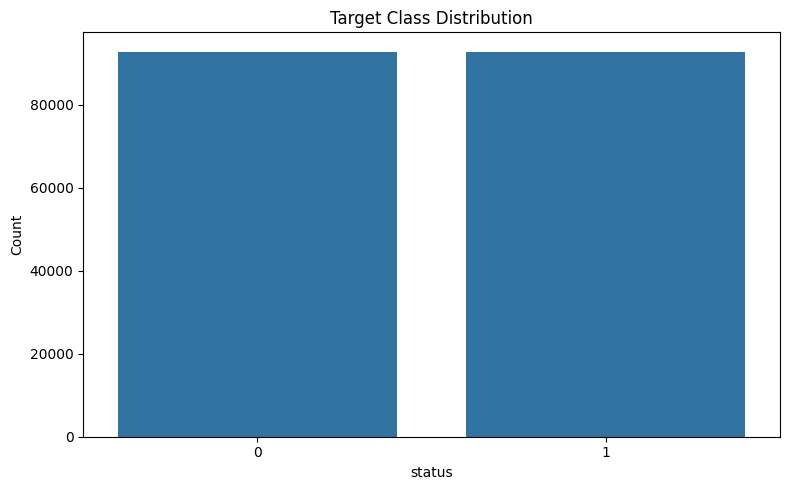

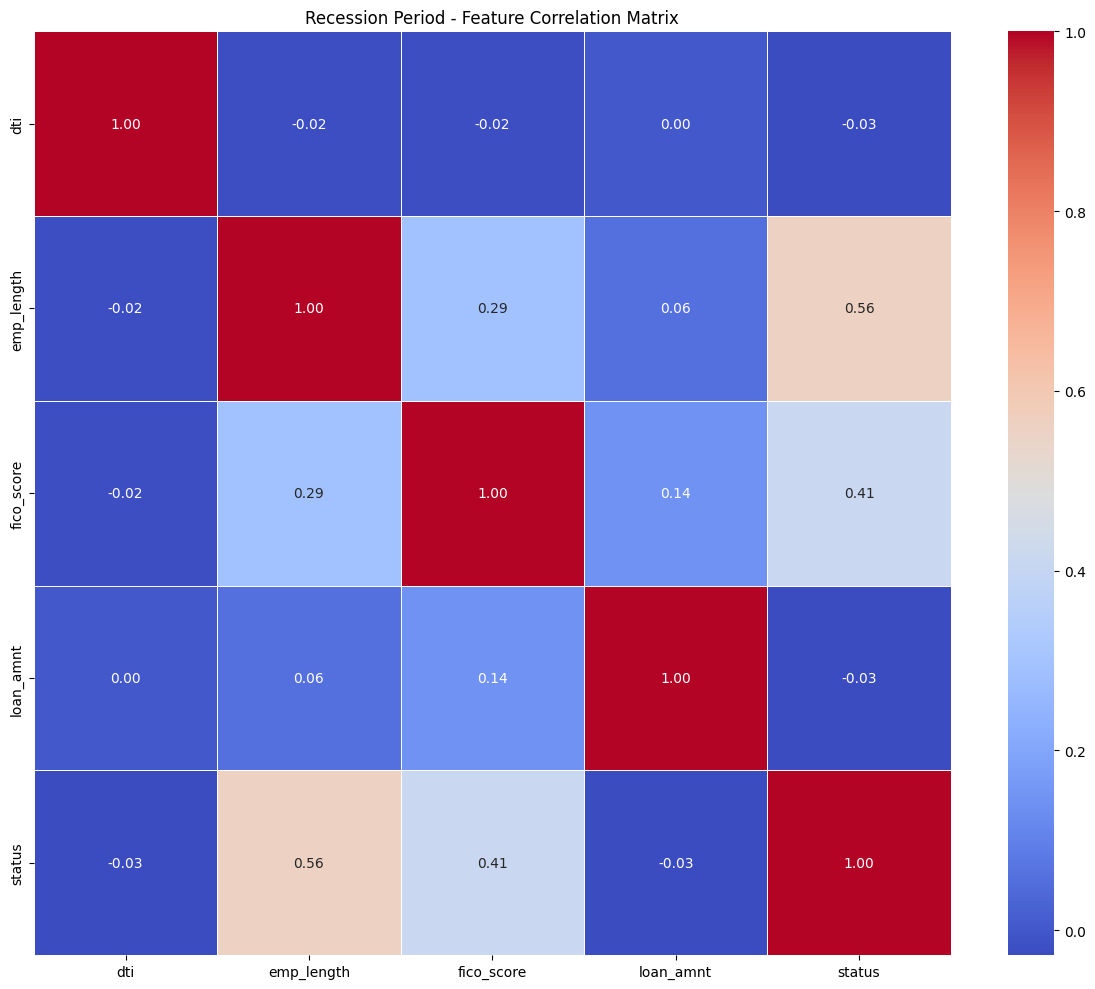

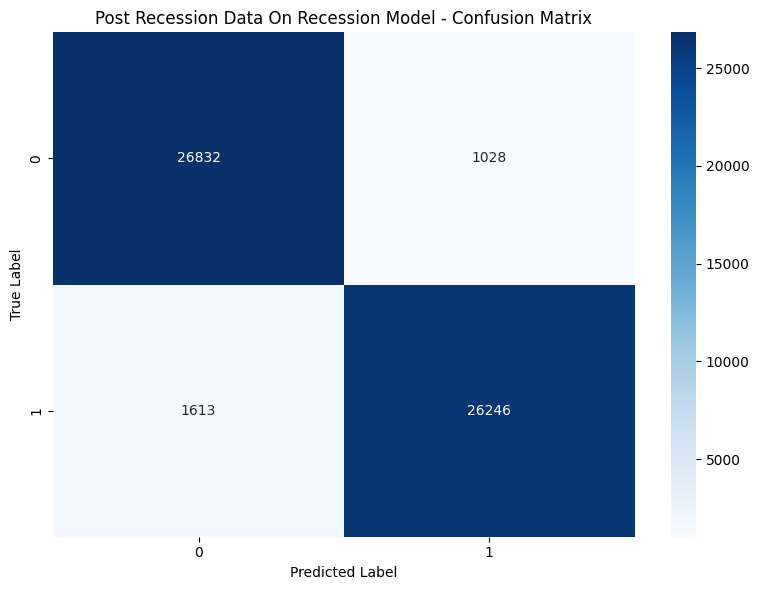


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     27860
           1       0.96      0.94      0.95     27859

    accuracy                           0.95     55719
   macro avg       0.95      0.95      0.95     55719
weighted avg       0.95      0.95      0.95     55719



In [19]:
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss'))
])
xgb_param_grid = {
        'model__n_estimators': [200],
        'model__max_depth': [5],
        'model__learning_rate': [0.2],
        'model__subsample': [1.0],
        'model__colsample_bytree': [0.8]
    }
cv=5

model_name = "Recession"
print("Starting recession prediction modeling pipeline...")
num_classes = len(np.unique(y_train))
avg_strategy = 'binary' if num_classes == 2 else 'weighted'
pos_label = 1 if avg_strategy == 'binary' else None

# Step 1: Data exploration and preprocessing
def load_and_explore_data(df):
    """
    Perform initial data exploration and preprocessing
    """
    print("Dataset Overview:")
    print(f"Shape: {df.shape}")
    print("\nData Types:")
    print(df.dtypes)
    
    # Check for missing values
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print("\nMissing Values:")
        print(missing[missing > 0])
        
    # Check for target class distribution
    print("\nTarget Distribution:")
    target_dist = df['status'].value_counts(normalize=True) * 100
    print(target_dist)
    
    # Plot target distribution
    plt.figure(figsize=(8, 5))
    sns.countplot(x='status', data=df)
    plt.title('Target Class Distribution')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('target_distribution.png')
    
    # Check for numeric feature correlations
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
    if len(numeric_features) > 1:
        plt.figure(figsize=(12, 10))
        correlation = df[numeric_features].corr()
        sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
        plt.title('Recession Period - Feature Correlation Matrix')
        plt.tight_layout()
    
    return df

def preprocess_data(df, target_column='status'):
    """
    Preprocess the data for modeling
    """
    # Define features (X) and target (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Encode target variable if categorical
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    print(f"\nEncoded target classes: {list(zip(le.classes_, range(len(le.classes_))))}")
    
    # Split data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded,
        test_size=0.3,
        random_state=42,
        stratify=y_encoded
    )
    
    print(f"\nTraining set shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")
    
    return X_train, X_test, y_train, y_test, le, X.columns

recession_df = load_and_explore_data(recession_df)
X_train, X_test, y_train, y_test, label_encoder, feature_names = preprocess_data(recession_df)

print(f"\nTuning...")
start_time = time.time()

# Set up grid search with cross-validation
grid_search = GridSearchCV(
    xgb_pipeline, 
    xgb_param_grid, 
    cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
    scoring='f1_weighted' if avg_strategy == 'weighted' else 'f1',
    n_jobs=-1,
    verbose=1
)

# Train the model
grid_search.fit(X_train, y_train)

# Display training performance
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values('rank_test_score').head(5)
print("\nTop 5 parameter combinations from CV:")
print(cv_results[['params', 'mean_test_score', 'std_test_score']])

# Make predictions on the test set
X_train, X_test, y_train, y_test, label_encoder, feature_names = preprocess_data(post_recession_df)
class_labels = label_encoder.classes_
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = None

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=avg_strategy, pos_label=pos_label, zero_division=0)
recall = recall_score(y_test, y_pred, average=avg_strategy, pos_label=pos_label, zero_division=0)
f1 = f1_score(y_test, y_pred, average=avg_strategy, pos_label=pos_label, zero_division=0)

print(f"\n--- {model_name} Results ---")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Training Time: {time.time() - start_time:.2f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title(f'Post Recession Data On Recession Model - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
class_names_str = [str(c) for c in class_labels]
print(classification_report(y_test, y_pred, target_names=class_names_str, zero_division=0))

Starting recession prediction modeling pipeline...
Dataset Overview:
Shape: (185730, 440)

Data Types:
dti           float64
emp_length    float64
fico_score    float64
loan_amnt     float64
status          int64
               ...   
state_VT         int8
state_WA         int8
state_WI         int8
state_WV         int8
state_WY         int8
Length: 440, dtype: object

Target Distribution:
status
1    50.0
0    50.0
Name: proportion, dtype: float64

Encoded target classes: [(0, 0), (1, 1)]

Training set shape: X=(130011, 439), y=(130011,)
Testing set shape: X=(55719, 439), y=(55719,)

Tuning...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Top 5 parameter combinations from CV:
                                              params  mean_test_score  \
0  {'model__colsample_bytree': 0.8, 'model__learn...         0.972225   

   std_test_score  
0        0.001624  

Encoded target classes: [(0, 0), (1, 1)]

Training set shape: X=(130011, 439), y=(130011,)
Testing set shape: X=(55719, 439), y=(55719,)

--- Recession Results ---
Best Parameters: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 200, 'model__subsample': 1.0}
Training Time: 28.70 seconds
Accuracy: 0.9556
Precision: 0.9430
Recall: 0.9699
F1-Score: 0.9563

Confusion Matrix:
[[26226  1634]
 [  838 27021]]


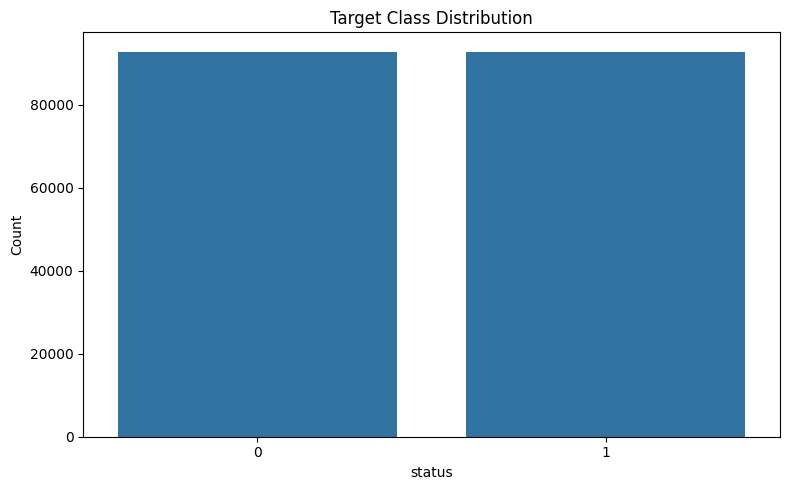

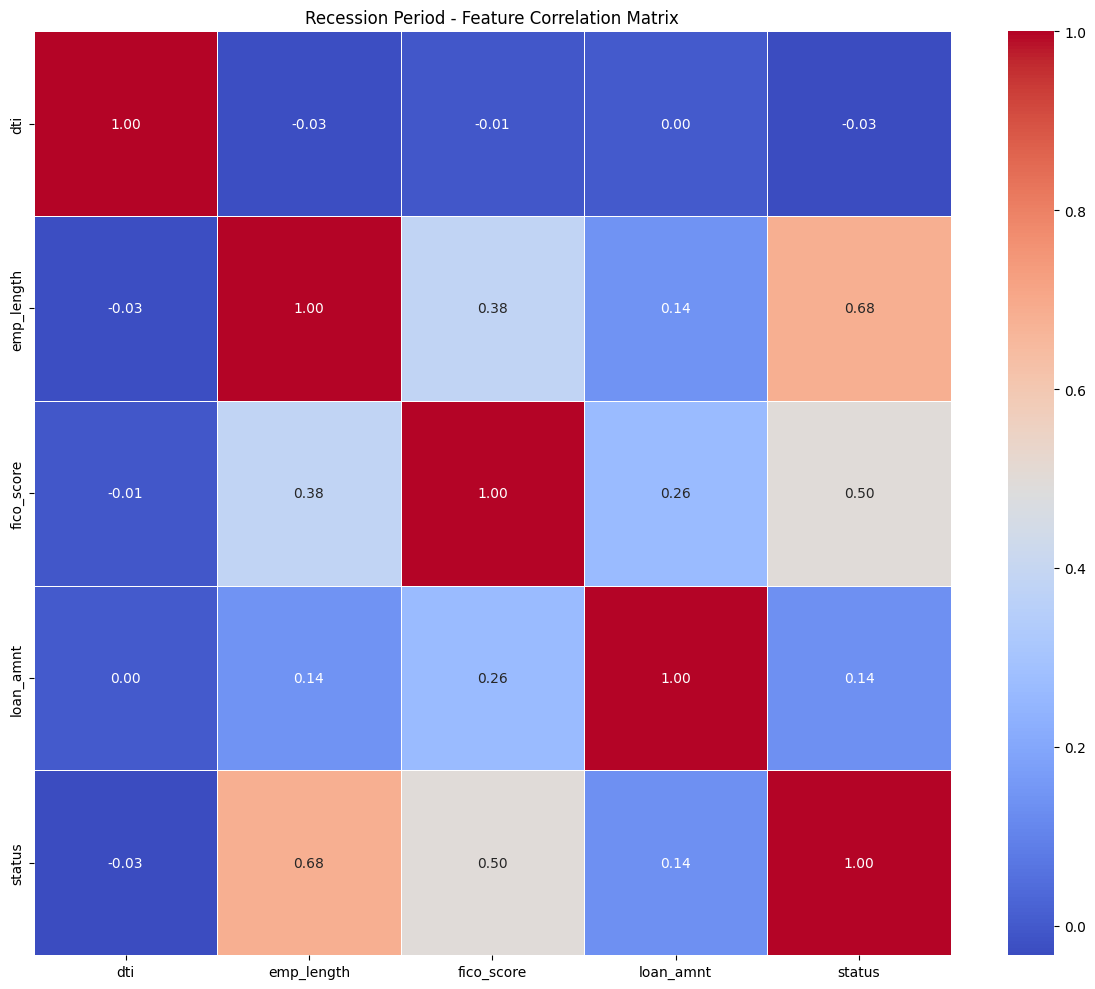

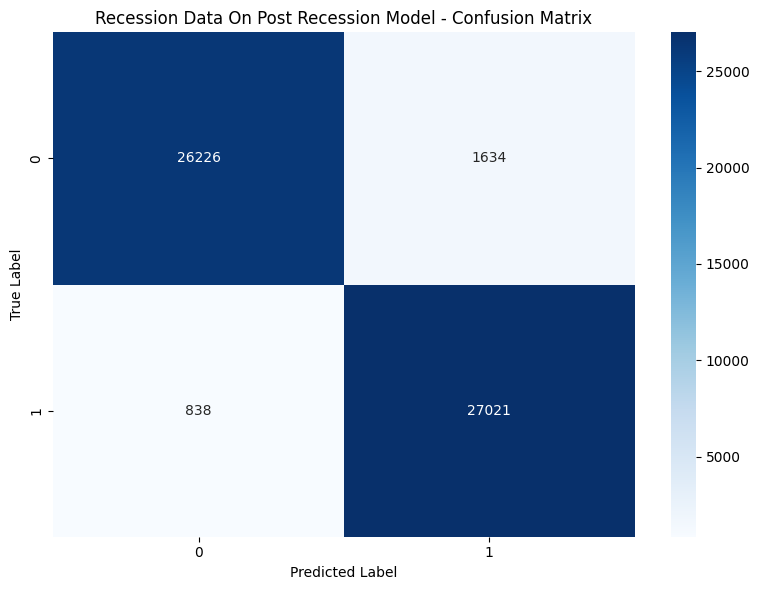


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95     27860
           1       0.94      0.97      0.96     27859

    accuracy                           0.96     55719
   macro avg       0.96      0.96      0.96     55719
weighted avg       0.96      0.96      0.96     55719



In [20]:
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss'))
])
xgb_param_grid = {
        'model__n_estimators': [200],
        'model__max_depth': [5],
        'model__learning_rate': [0.2],
        'model__subsample': [1.0],
        'model__colsample_bytree': [0.8]
    }
cv=5

model_name = "Recession"
print("Starting recession prediction modeling pipeline...")
num_classes = len(np.unique(y_train))
avg_strategy = 'binary' if num_classes == 2 else 'weighted'
pos_label = 1 if avg_strategy == 'binary' else None

# Step 1: Data exploration and preprocessing
def load_and_explore_data(df):
    """
    Perform initial data exploration and preprocessing
    """
    print("Dataset Overview:")
    print(f"Shape: {df.shape}")
    print("\nData Types:")
    print(df.dtypes)
    
    # Check for missing values
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print("\nMissing Values:")
        print(missing[missing > 0])
        
    # Check for target class distribution
    print("\nTarget Distribution:")
    target_dist = df['status'].value_counts(normalize=True) * 100
    print(target_dist)
    
    # Plot target distribution
    plt.figure(figsize=(8, 5))
    sns.countplot(x='status', data=df)
    plt.title('Target Class Distribution')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('target_distribution.png')
    
    # Check for numeric feature correlations
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
    if len(numeric_features) > 1:
        plt.figure(figsize=(12, 10))
        correlation = df[numeric_features].corr()
        sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
        plt.title('Recession Period - Feature Correlation Matrix')
        plt.tight_layout()
    
    return df

def preprocess_data(df, target_column='status'):
    """
    Preprocess the data for modeling
    """
    # Define features (X) and target (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Encode target variable if categorical
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    print(f"\nEncoded target classes: {list(zip(le.classes_, range(len(le.classes_))))}")
    
    # Split data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded,
        test_size=0.3,
        random_state=42,
        stratify=y_encoded
    )
    
    print(f"\nTraining set shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")
    
    return X_train, X_test, y_train, y_test, le, X.columns

post_recession_df = load_and_explore_data(post_recession_df)
X_train, X_test, y_train, y_test, label_encoder, feature_names = preprocess_data(post_recession_df)

print(f"\nTuning...")
start_time = time.time()

# Set up grid search with cross-validation
grid_search = GridSearchCV(
    xgb_pipeline, 
    xgb_param_grid, 
    cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
    scoring='f1_weighted' if avg_strategy == 'weighted' else 'f1',
    n_jobs=-1,
    verbose=1
)

# Train the model
grid_search.fit(X_train, y_train)

# Display training performance
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values('rank_test_score').head(5)
print("\nTop 5 parameter combinations from CV:")
print(cv_results[['params', 'mean_test_score', 'std_test_score']])

# Make predictions on the test set
X_train, X_test, y_train, y_test, label_encoder, feature_names = preprocess_data(recession_df)
class_labels = label_encoder.classes_
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = None

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=avg_strategy, pos_label=pos_label, zero_division=0)
recall = recall_score(y_test, y_pred, average=avg_strategy, pos_label=pos_label, zero_division=0)
f1 = f1_score(y_test, y_pred, average=avg_strategy, pos_label=pos_label, zero_division=0)

print(f"\n--- {model_name} Results ---")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Training Time: {time.time() - start_time:.2f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title(f'Recession Data On Post Recession Model - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
class_names_str = [str(c) for c in class_labels]
print(classification_report(y_test, y_pred, target_names=class_names_str, zero_division=0))